# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Необходимо определить рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Открытие файла, изучение общей информации

In [1]:
# Загрузим все необходимые для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [3]:
pd.set_option('display.max_columns', None)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


---
Проанализируем первоначальные данные, путем построения гистограмм, использованием метода `describe()`, а также построим тепловую карту. Визуализировав таким образом данные будет достаточно просто подвести какие-либо выводы. 

---

### Гистограмма по каждому из столбцов

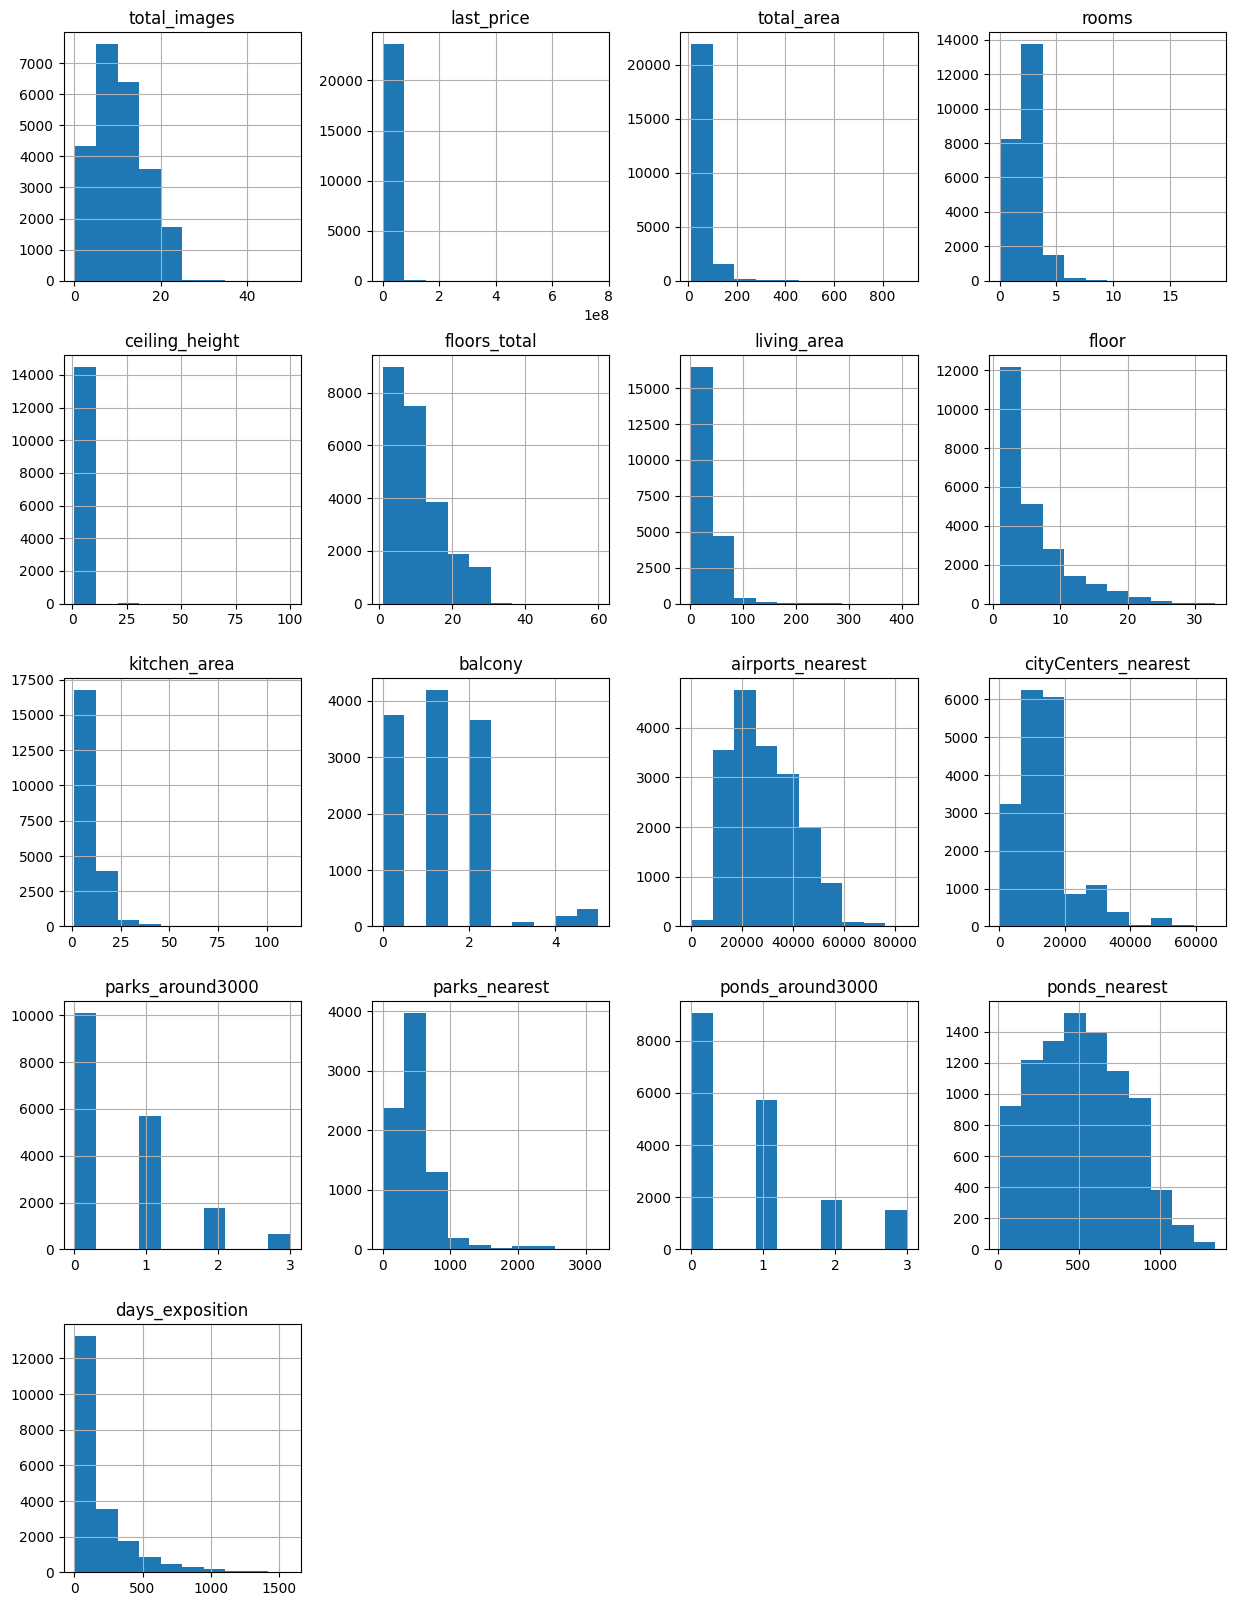

In [4]:
# построим гистограммы
data.hist(figsize=(15, 20));

### Общая информация о датафрейме

In [5]:
# рассмотрим дополнительную информацию по столбцам. например - среднее, квантили, минимальные и максимальные значения:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Тепловая карта

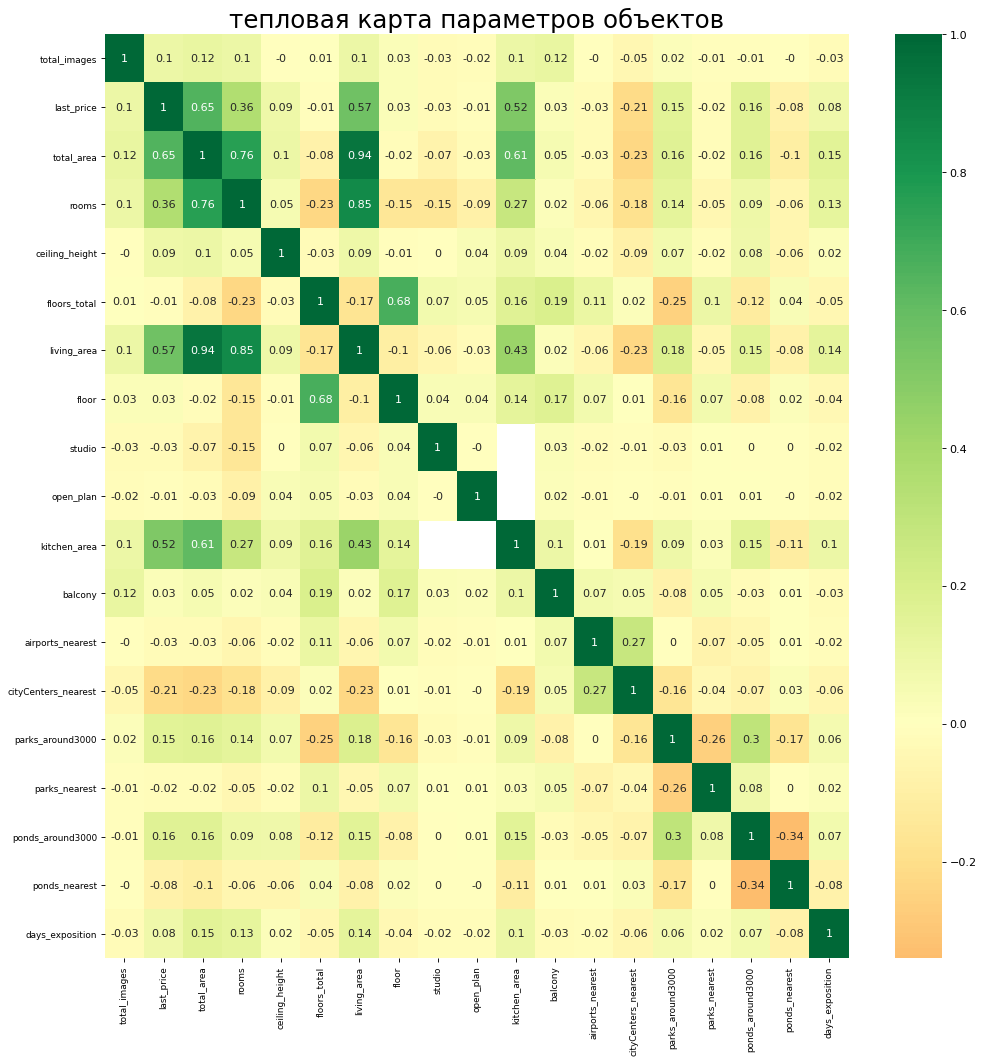

In [6]:
# выведем тепловую карту корелляции столбцов между собой
plt.figure(figsize=(15,15), dpi= 80)
sns.heatmap(np.round(data.corr(), 2), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('тепловая карта параметров объектов', fontsize=22)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Дополнительные `plot`

Построим две отдельные гистограммы по самым важным параметрам жилья - стоимостью и общей площадью

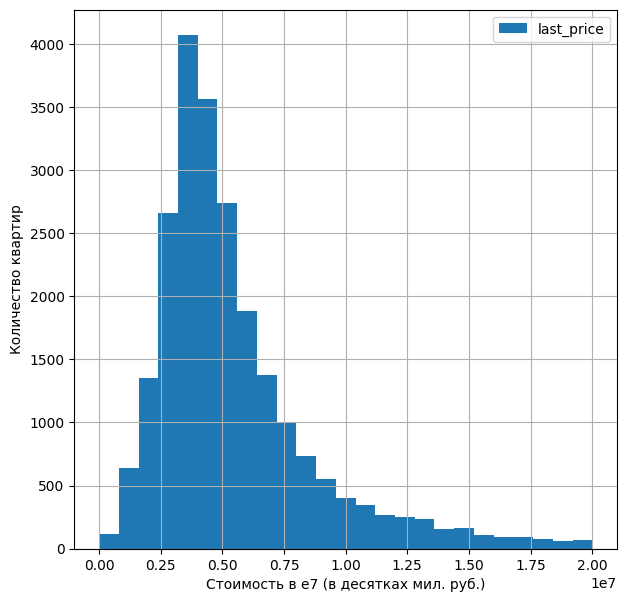

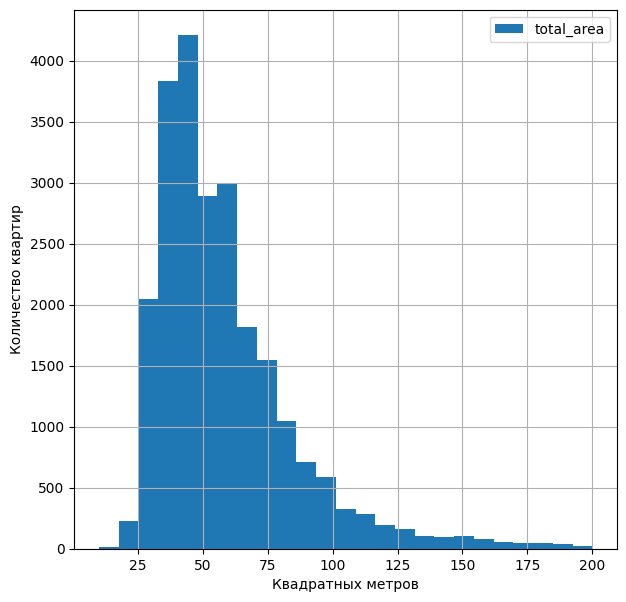

In [7]:
# гистограмма по значениям столбца 'last_price' от min до третьего квантиля
data.plot(
    kind='hist',
    y='last_price',
    figsize=(7,7),
    histtype='bar',
    range=(0, 20000000),
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество квартир')
plt.xlabel('Стоимость в e7 (в десятках мил. руб.)')
plt.show()

# исходя из первичной гистограммы, можно заметить, что большинство данных находятся в пределах 200 кв. м.
# создадим гистограмму с пределом значения в 200 кв. м по столбцу 'total_area'
data.plot(
    kind='hist',
    y='total_area',
    figsize=(7,7),
    histtype='bar',
    range=(10, 200),
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество квартир')
plt.xlabel('Квадратных метров')
plt.show()

### Вывод
Из имеющейся информации можно сделать выводы разных типов:

1. **Типы данных столбцов:**
 - `first_day_exposition` - в `object` формате, вместо `datetime`
 - `ceiling_height`, `Last_price`, `floors_total`, `balcony`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000`, `days_exposition` - эти столбцы выглядят так, будто они должны быть формата `int`
2. **Значения в столбцах:**
  - `last_price`- значение в **763** миллиона рублей выглядит подозрительно большим. может быть ошибка в порядке числа? **7.63**, либо  **76.3** миллиона рублей. Также могу допустить, что в объявлении выставлен целый комплекс/вилла с огромным метражом, в таком случае цена может быть реальна
 - `rooms` - минимальное значение в **0** комнат - явная ошибка
 - `is_apartment` - все видимые значения из шапки - `NaN`, стоит обратить на этот столбец внимание
 - `ceiling_height` - минимальное значение в **1** метр как и максимальное значение в **100** метров выглядят либо как ошибки, либо как некорректно предоставленная информация со стороны продавца недвижимости
 - `airport_nearest` - минимальное значение в **0** говорит о том, что продается жильё прямо в аэропорту. Слабо верится.
 - `days_exposition` - квартиры продавались как и минимально за **1** день, так и максимально за **1580** дней, а в среднем на продажу уходит 180 дней.
 - Во многих столбцах есть пропущеные значения - необходимо их обработать в зависимости от контекста данных
3. **Корреляции между столбцами:** В первичных данных видны корреляции между столбцами (думаю на остальные корреляции обращать внимание пока не стоит):
 - `last_price` - `total_area` - **высокая корреляция** - `0.65` - логично предположить, что чем больше метраж, тем выше цена
 - `last_price` - `rooms` - **средняя корреляция** - `0.36` - есть небольшая связь между тем, насколько больше комнат - выше стоимость квартиры. Соответственно это связано и с общей площадью.
 - `last_price` - `kitchen_area`/`living_area` - **средняя корреляция** - `0.52` и `0.57` - логично предположить, что чем больше размеры кухни и жилой площади, тем выше стоимость квартиры. Соответственно это связано и с общей площадью
 - `last_price` - `cityCenters_nearest` - **небольшая отрицательная корреляция** - `-0.21` - заметная небольшая отрицательная корреляция между близостью к центру и увеличением цены. Так обычно и бывает - чем ближе к центру, тем дороже стоимость жилья.
4. **Стоимость жилья, размеры жилья:**
 - `last_price` - из гистограммы видно, что большая часть квартир располагается в стоимости между 1 и 10 миллионами рублей, тогда как большая часть из этой выборки находится в промежутке от 2 до 6 миллионов рублей. Объявления с жильём стоимостью выше 10 миллионов рублей достаточно редки, относительно общего числа выставленных объявлений.
 - `total_area` - гистограмма очень похожа на гистограмму стоимости жилья. Также можно отметить, что большая часть жилья располагается в промежутке от 25 до 100 квадратных метров, и средняя по этой выборке примерно в 50 квадратных метров.

## Предобработка данных

Предобработку выполним в такой последовательности:
1. Проведем анализ столбцов, в которых содержатся пропуски
2. Проведем проверку на наличие дубликатов явных/неявных, обработаем их 
3. Проведем обработку столбцов с пропусками, и заменим пропуски на необходимые значения
4. Проведем изменения типов данных
5. Обработка аномальных значений в столбцах

### Анализ столбцов и планирование дальнейших действий

Давайте рассмотрим, сколько пропусков в каждом из столбцов:

In [8]:
# создадим переменную, в которой будут содержаться все столбцы с пропущенными значениями
null_values = data.isnull().sum()
null_values = null_values[null_values > 0]
null_values.sort_values(inplace=True)
null_values

locality_name             49
floors_total              86
living_area             1903
kitchen_area            2278
days_exposition         3181
parks_around3000        5518
ponds_around3000        5518
cityCenters_nearest     5519
airports_nearest        5542
ceiling_height          9195
balcony                11519
ponds_nearest          14589
parks_nearest          15620
is_apartment           20924
dtype: int64

1. Круговая диаграмма столбца с пропущенными значениями "locality_name"


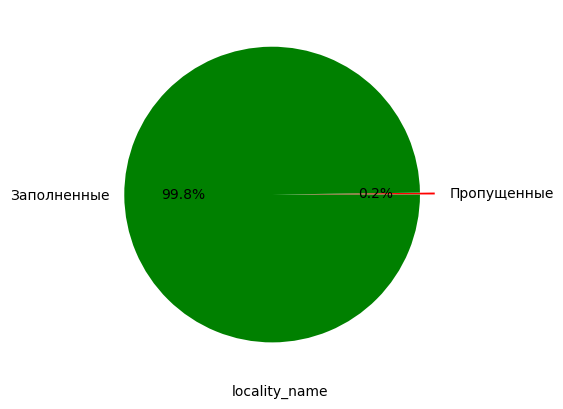

2. Круговая диаграмма столбца с пропущенными значениями "floors_total"


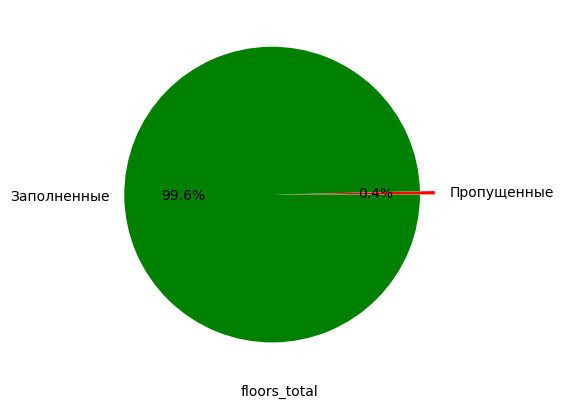

3. Круговая диаграмма столбца с пропущенными значениями "living_area"


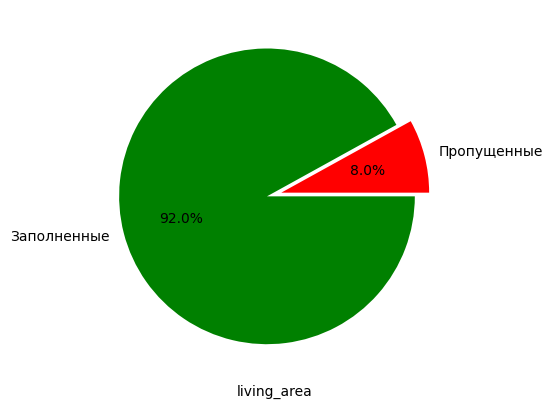

4. Круговая диаграмма столбца с пропущенными значениями "kitchen_area"


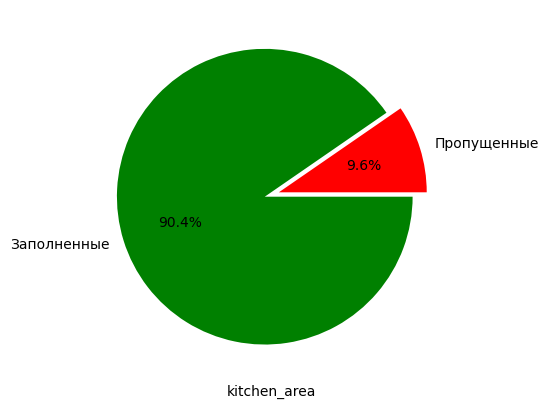

5. Круговая диаграмма столбца с пропущенными значениями "days_exposition"


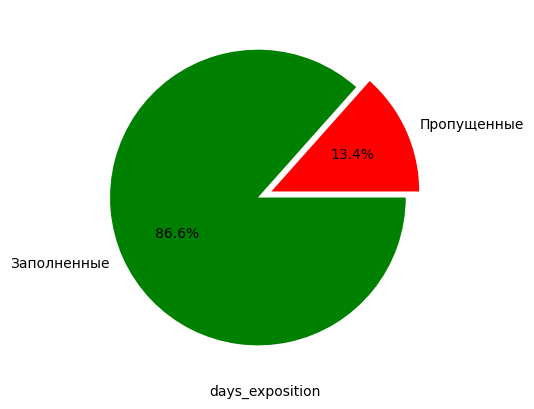

6. Круговая диаграмма столбца с пропущенными значениями "parks_around3000"


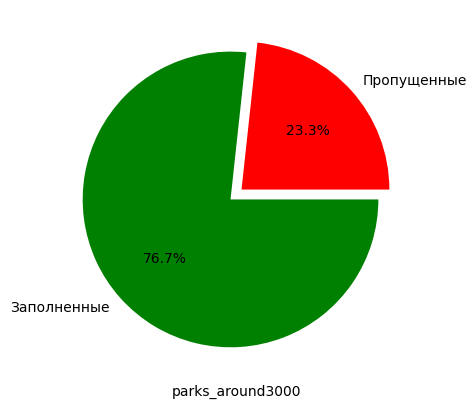

7. Круговая диаграмма столбца с пропущенными значениями "ponds_around3000"


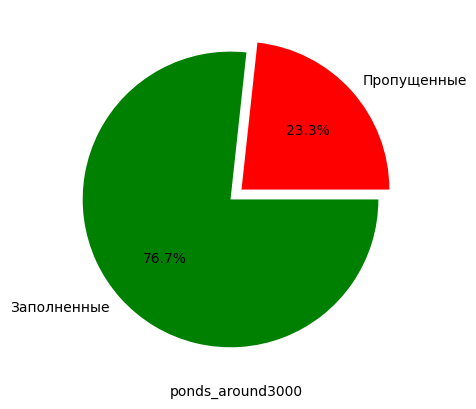

8. Круговая диаграмма столбца с пропущенными значениями "cityCenters_nearest"


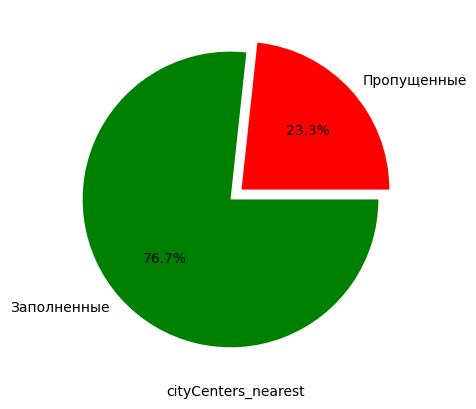

9. Круговая диаграмма столбца с пропущенными значениями "airports_nearest"


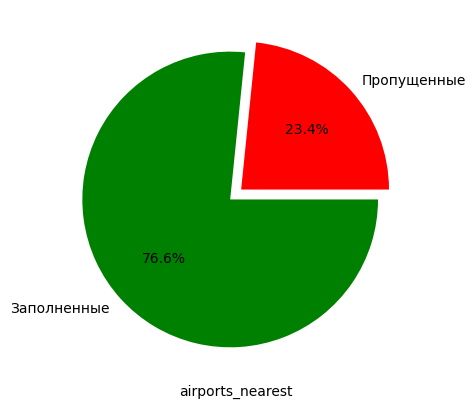

10. Круговая диаграмма столбца с пропущенными значениями "ceiling_height"


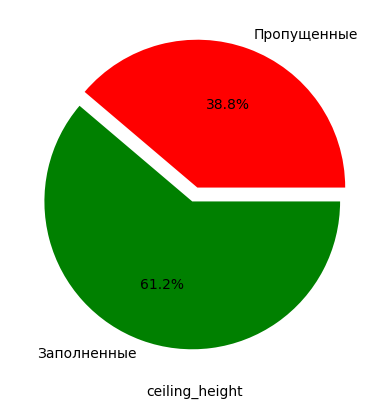

11. Круговая диаграмма столбца с пропущенными значениями "balcony"


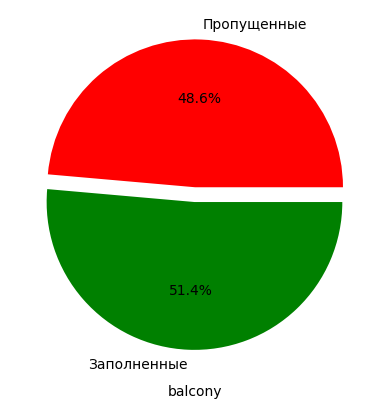

12. Круговая диаграмма столбца с пропущенными значениями "ponds_nearest"


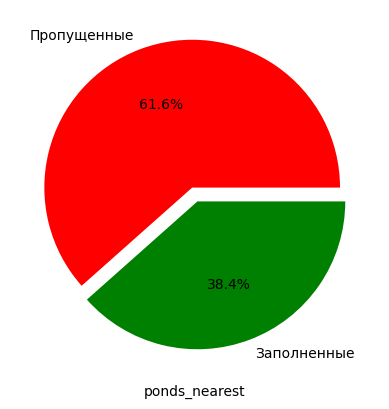

13. Круговая диаграмма столбца с пропущенными значениями "parks_nearest"


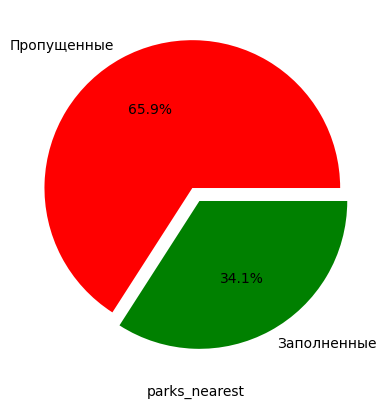

14. Круговая диаграмма столбца с пропущенными значениями "is_apartment"


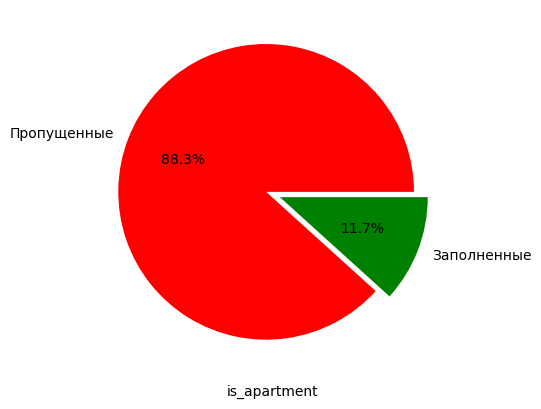

In [9]:
i = 0
# напишем цикл, который будет считать процентные значения пропущенных/заполненных данных относительно общего количества строк
for column in null_values.index:
    percentage_missing = (null_values[column] / len(data)) * 100
    percentage_filled = 100 - percentage_missing
    
    # создадим переменные, которые будут описывать круговую диаграмму
    sizes = [percentage_missing, percentage_filled]
    labels = ['Пропущенные', 'Заполненные']
    
    # создадим датафрейм для круговой диаграммы
    pie_data = pd.DataFrame(sizes, index=labels, columns=[column])
    
    explode = (0.05, 0.05) 
   
    i += 1
    
    # создание круговой диаграммы с помощью .plot Pandas
    pie_data[column].plot(
        kind='pie',
        autopct='%1.1f%%',
        colors=['red', 'green'],
        explode=explode
    )
    print(f'{i}. Круговая диаграмма столбца с пропущенными значениями "{column}"')
    plt.ylabel('')
    plt.xlabel(column)
    plt.show()
    
# хотелось привести круговые диаграммы в несколько рядов, а не в столбец, но не получилось реализовать эту идею.
# в таком виде информация выглядит очень нагроможденно

---
#### Подробный разбор столбцов, выявление причин пропусков

Анализ будет в простом формате: 
 - 1 - небольшой анализ данных,
 - 2 - причины, по которым могли возникнуть пропуски
 - 3 - действия, которые стоит предпринять

---

1. Название населенного пункта -`locality_name` - **49** пропусков, **0.2%** от общего количества строк:
   1. Самое маленькое количество пропусков среди всего датафрейма. Для анализа данных такое малое количество строк может и не повлияет общий результат, но учитывая, что данные собираются по Ленинградской области, можно указать самое популярное значение - **Санкт-Петербург**
   2. Пропусков очень мало, и я считаю, что такая графа как адрес должна быть обязательной при заполнении. Вероятно пропуски связаны с ошибками при сборе/выгрузке данных.
   3. Оставить строки как есть.

2. Количество этажей в доме- `floors_total`- **86** пропусков, **0.4%** от общего количества строк:
   1. Мизерное количество пропусков относительно общего количества данных. Количество этажей в доме может быть каким угодно, и заполнять значения медианными, средними или какими-то еще, как мне кажется, будет ошибкой.
   2. Пропуски могут быть связаны с невнимательностью при заполнении информации в объявлении.
   3. Оставить строки не имеющие `floors_total`

3. Жилая площадь - `living_area` - **1903** пропусков, **8%** от общего количества строк:
   1. На гистограмме видно по распределению данных, что квартиры с большим метражом - 400+ кв. м достаточно редки, а большинство данных в пределах 100 кв. м. 
   2. В этом столбце пропусков значительно больше, чем в столбцах выше. Такое количество пропусков может быть связано с ошибками при сборе/выгрузке данных, или же информация изначально была пропущена и не указана.
   3. Найдем соотношений кухноной площади к средней общей площади, и с помощью выведенного значения заменим пропуски

4. Площадь кухни - `kitchen_area` - **2278** пропусков, **9.6%** от общего количества строк:
   1. На гистограмме видно по распределению данных, что в большинстве случаев площадь кухни находится в пределах 25 кв. м..
   2. В этом столбце количество пропусков примерно равно столбцу 'living_area', и мы уже видели по тепловой карте, что эти столбцы между собой связаны. Причины пропусков те же самые.
   3. Найдем соотношений кухноной площади к средней общей площади, и с помощью выведенного значения заменим пропуски   

5. Количество дней размещения объявления - `days_exposition` - **3181** пропусков, **13.4%** от общего количества строк:
   1. При выводе информации методом `describe()` мы увидели, что в большинстве случаев жилье в *среднем* продается в течение **180** дней, тогда как медиана говорит нам о **95** днях. Бывают и исключения из правил, а может это и ошибочные данные - продажи квартир за **1** и **1580** дней тому подтверждения.
   2. Эта информация подтягивается автоматически из сервиса по продаже. Вероятно пропуски связаны с ошибками при выгрузке данных. Также смею допустить, что есть небольшая часть объявлений, которые выставлены в первые сутки или же в первую половину суток с момента выставления объявления, и в таком случае, если происходит какое-либо округление, такие значения идут в сторону 0 и могут выводиться как NaN. Такую важную информацию заменять на медианное или среднее значение не имеет никакого смысла.
   3. Оставить данные как есть.

6. Количество водоёмов/парков в радиусе 3 км - `parks_around3000`, `ponds_around3000`: **5518, 5518** пропусков - **23.3%, 23.3%** от общего количества строк:
   1. Пропуски в этих столбцах могут говорить о том, что в расстоянии 3 км от объекта не находится ни один парк/водоём.
   2. Столбцы были сгенерированы автоматически, поэтому пропуски моугт быть связаны с ошибками выгрузки или сбора информации, а также неправильным форматированием данных - некоторые нули могли быть заменены на NaN
   3. Заменим пропуски на 0

7. Расстояние до центра/аэропорта- `cityCenters_nearest`, `airports_nearest`: **5519, 5542** пропусков - **23.3%, 23.4%** соответственно от общего количества строк:
   1. Пропуски в этих столбцах вряд ли могут быть заменены на какую-то логичную информацию.
   2. Столбцы были сгенерированы автоматически, поэтому пропуски моугт быть связаны с ошибками выгрузки или сбора информации, а также неправильным форматированием данных - некоторые нули могли быть заменены на NaN
   3. Оставить данные как есть. 

8. Высота потолка - `ceiling_height` - **9195** пропусков, **38.8%** от общего количества строк:
   1. В среднем, высота потолка варьируется от ~2 до 3 метров, лишь выбросы имеют большие или меньшие значения. Количество пропусков относительно общего количества строк высокое.
   2. Такое количество пропусков может говорить о том, что причин пропусков было несколько. Например, продающие собственность не имеют на руках информации о высоте потолков. Вторая причина - невнимательность при заполнении данных в анкете. И третья - ошибки при выгрузке данных.
   3. Сгруппировать данные по населенным пунктам, заменить пропуски на средние значения по этим объектам

9. Количество балконов в доме - `balcony` - **11519** пропусков, **48.6%** от общего количества строк:
   1. Половина значений в столбце пропущена. Вероятно балконов в этих квартирах нет вовсе.
   2. Пропуски могут быть связаны с недостаточно информативным интерфейсом для заполнения данных - возможно пользователю не показано, что при отсутствии балконов нужно отметить это, а не оставлять поле пустым.
   3. Заменить пропуски на `0`
      
10. Расстояние до ближайшего водоёма/парка- `parks_nearest`, `ponds_nearest` - **15620**, **14589** пропусков - **65.9%**, **61.6%** соответственно от общего количества строк:
 - Огромное количество пропусков в этих столбцах. 
 - Столбцы были сгенерированы автоматически, поэтому пропуски моугт быть связаны с ошибками выгрузки или сбора информации.
 - Оставить данные как есть.
      
11. Является квартирой - `is_apartment` - **20924** пропусков, **88.3%** от общего количества строк:
 - Самое большое количество пропусков среди всех данных. Сложно назвать точную причину, по которой допущено такое количество пропусков. Хочу заметить, что значение слова apartment в разных языках воспринимается по-разному, и на английском языке apartment является квартирой, тогда как на русском языке апартаменты это нежилая недвижимость. В апартамента нельзя получить постоянную регистрацию — только временную по месту пребывания, и это важный фактор. Но если все же взять во внимание дополнительное описание к проекту, то там обозначено, что is_apartment это всё же апартаменты, а не квартира.
 - Единственное предположение которое более менее похоже на правду, что эта графа появилась в последние месяцы работы сервиса, и во всех предыдущих данных (до определенного момента) отсуствуют значения в этом столбце.
 - Заменить пропуски на значение `False`

In [10]:
# рассмотрим, какие бывают locality_name
data['locality_name'].value_counts()

Санкт-Петербург           15721
посёлок Мурино              522
посёлок Шушары              440
Всеволожск                  398
Пушкин                      369
                          ...  
деревня Щеглово               1
деревня Кисельня              1
деревня Нижние Осельки        1
деревня Шпаньково             1
деревня Трубников Бор         1
Name: locality_name, Length: 364, dtype: int64

Самым популярным значением является "Санкт-Петербург".

### Проверка на наличие дубликатов  и их обработка

Проверим датафрейм на наличие явных дубликатов:

In [11]:
data.duplicated().sum()

0

---
В столбце `locality_name` содержится огромное количество значений. Попробуем обобщить данные по этому столбцу, убрав ключевые слова из названий:

In [12]:
data['locality_name'].value_counts()

Санкт-Петербург           15721
посёлок Мурино              522
посёлок Шушары              440
Всеволожск                  398
Пушкин                      369
                          ...  
деревня Щеглово               1
деревня Кисельня              1
деревня Нижние Осельки        1
деревня Шпаньково             1
деревня Трубников Бор         1
Name: locality_name, Length: 364, dtype: int64

In [13]:
# поищем, какие ключевые слова по типу "поселок" могут встречаться в столбце
data_with_no_na = data.dropna(subset=['locality_name'])
data_with_no_na = data_with_no_na[data_with_no_na['locality_name'].str.contains(' ')] 
data_with_no_na.groupby('locality_name')['last_price'].count().tail(20)

locality_name
посёлок городского типа имени Морозова                     17
посёлок городского типа имени Свердлова                    11
посёлок при железнодорожной станции Вещево                  1
посёлок при железнодорожной станции Приветнинское           1
посёлок станции Громово                                     3
посёлок станции Свирь                                       2
садоводческое некоммерческое товарищество Лесная Поляна     1
садовое товарищество Новая Ропша                            1
садовое товарищество Приладожский                           1
садовое товарищество Рахья                                  1
садовое товарищество Садко                                  1
село Копорье                                                5
село Никольское                                             1
село Павлово                                                7
село Паша                                                   2
село Путилово                                           

In [14]:
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок ','Пансионат ', 'при железнодорожной ', 'деревня ','садоводческое некоммерческое товарищество ', 'село ', 'станции ','городского типа ','городской ', 'имени ', 'коттеджный ', 'при железнодорожной станции ', 'садовое товарищество '], '', regex=True)
) 

In [15]:
# проверим, есть ли еще какие-то слова, которые можно заменить
data_with_no_na = data.dropna(subset=['locality_name'])
data_with_no_na = data_with_no_na[data_with_no_na['locality_name'].str.contains(' ')] 
print(data_with_no_na.groupby('locality_name')['last_price'].count().head(20))
print(data_with_no_na.groupby('locality_name')['last_price'].count().tail(20))

locality_name
Большая Вруда           4
Большая Ижора          17
Большая Пустомержа      1
Большие Колпаны        16
Большое Рейзино         1
Большой Сабск           1
Борисова Грива          1
Вахнова Кара            1
Дружная Горка           5
Зеленый Бор             2
Кивеннапа Север         1
Красная Долина          3
Красное Село          178
Красный Бор             8
Лесная Поляна           1
Лисий Нос               3
Лодейное Поле          20
Малая Романовка         1
Малое Верево           11
Малое Карлино           9
Name: last_price, dtype: int64
locality_name
Малая Романовка              1
Малое Верево                11
Малое Карлино                9
Малые Колпаны                7
Нижние Осельки               1
Новая Ладога                14
Новая Ропша                  1
Новое Девяткино            144
Новый Свет                  22
Новый Учхоз                  6
Платформа 69-й километр      1
Сосновый Бор                87
Старая Ладога                2
Старая Малукса    

In [16]:
data['locality_name'].value_counts()

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Левашово               1
Мыза-Ивановка          1
Сижно                  1
Реброво                1
Рапполово              1
Name: locality_name, Length: 305, dtype: int64

Таким образом мы исправили **59** неявных дубликатов.

### Обработка аномальных значений в столбцах

Пройдемся по всем столбцам, которые вызывают вопросы, и выведем аномальные значения

#### Столбец `last_price`

#### выведем шапку из 10 отсортированных значений по убывающей
data.sort_values(by='last_price', ascending=False).head(10)

Для удобства чтения цен разделим значения в last_price до миллионов и выведем в отдельном столбце:

In [17]:
data['last_price_mil'] = data['last_price']/1000000
data_columns = list(data.columns)
data_columns.insert(2, data_columns.pop(-1))
data = data[data_columns]

<AxesSubplot:>

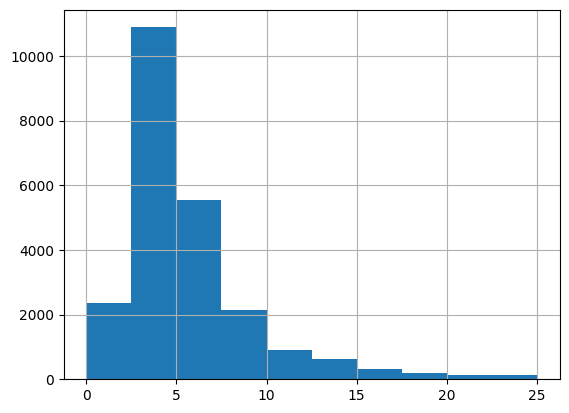

In [18]:
data['last_price_mil'].hist(
    range=(0, 25)
)

Объявления стоимостью выше выглядят подозрительно дорогими, не подходящими к анализу данных. 

Можем создать новый датафрейм, срезав ненужные аномально дорогие объявления.

In [19]:
good_data = data.query('last_price_mil <= 25').reset_index(drop=True)
good_data.head(10)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,13.000,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,3.350,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,5.196,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,2,10000000.0,10.000,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
4,10,2890000.0,2.890,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
5,6,3700000.0,3.700,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
6,5,7915000.0,7.915,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
7,20,2900000.0,2.900,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
8,18,5400000.0,5.400,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
9,5,5050000.0,5.050,39.60,2017-11-16T00:00:00,1,2.67,12.0,20.30,3,NaN,False,False,8.50,NaN,Санкт-Петербург,38357.0,13878.0,1.0,310.0,2.0,553.0,137.0


In [20]:
# выведем шапку из 20 отсортированных значений по убывающей
good_data.sort_values(by='last_price_mil', ascending=False).head(10)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
16998,18,25000000.0,25.0,134.0,2016-12-01T00:00:00,7,3.29,6.0,104.00,2,NaN,False,False,11.20,0.0,Санкт-Петербург,25257.0,6060.0,1.0,761.0,1.0,584.0,278.0
19611,15,25000000.0,25.0,102.0,2017-06-15T00:00:00,3,3.00,17.0,56.53,15,NaN,False,False,15.85,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,180.0
9594,13,25000000.0,25.0,77.0,2015-11-10T00:00:00,2,3.32,6.0,55.20,1,False,False,False,NaN,NaN,Санкт-Петербург,22379.0,3028.0,2.0,942.0,1.0,169.0,NaN
1157,10,25000000.0,25.0,201.0,2015-08-07T00:00:00,5,3.50,6.0,131.00,4,False,False,False,35.00,NaN,Санкт-Петербург,26752.0,5458.0,3.0,445.0,0.0,NaN,1117.0
15538,6,25000000.0,25.0,145.2,2014-11-27T00:00:00,3,NaN,5.0,60.70,5,NaN,False,False,40.20,NaN,Санкт-Петербург,36779.0,14931.0,0.0,NaN,0.0,NaN,NaN
21977,12,25000000.0,25.0,196.0,2016-11-04T00:00:00,7,3.50,6.0,145.00,5,NaN,False,False,17.00,1.0,Санкт-Петербург,25083.0,3658.0,1.0,552.0,0.0,NaN,NaN
5288,3,25000000.0,25.0,127.0,2019-01-24T00:00:00,5,3.20,6.0,90.00,6,NaN,False,False,NaN,NaN,Санкт-Петербург,25420.0,4267.0,1.0,432.0,3.0,357.0,8.0
6550,8,25000000.0,25.0,93.0,2017-03-17T00:00:00,3,NaN,5.0,35.70,4,NaN,False,False,46.80,NaN,Санкт-Петербург,22688.0,2130.0,0.0,NaN,1.0,323.0,434.0
8927,9,25000000.0,25.0,138.2,2019-04-04T00:00:00,4,2.58,16.0,70.60,10,NaN,False,False,10.60,2.0,Санкт-Петербург,37284.0,12805.0,1.0,457.0,0.0,NaN,9.0
18191,20,25000000.0,25.0,130.0,2017-11-29T00:00:00,3,3.37,6.0,66.90,4,NaN,False,False,27.40,NaN,Санкт-Петербург,23568.0,1898.0,3.0,515.0,3.0,264.0,212.0


#### Столбец `total_area`

In [21]:
# выведем шапку из 20 отсортированных значений по убывающей
good_data.sort_values(by='total_area', ascending=False).head(20)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
19868,12,20000000.0,20.000,460.8,2019-03-20T00:00:00,6,3.10,3.0,279.6,1,NaN,False,False,55.50,NaN,Санкт-Петербург,43756.0,15459.0,1.0,852.0,3.0,122.0,21.0
841,5,25000000.0,25.000,363.0,2017-12-23T00:00:00,14,3.16,5.0,222.0,4,NaN,False,False,16.60,NaN,Санкт-Петербург,38076.0,7950.0,0.0,NaN,2.0,435.0,418.0
10873,3,14000000.0,14.000,320.0,2017-09-27T00:00:00,6,NaN,3.0,190.0,3,NaN,False,False,28.00,0.0,Красное Село,26020.0,29445.0,1.0,569.0,0.0,NaN,8.0
11212,4,24000000.0,24.000,316.3,2015-03-25T00:00:00,8,NaN,5.0,187.0,5,NaN,False,False,NaN,0.0,Санкт-Петербург,24555.0,5129.0,0.0,NaN,1.0,934.0,542.0
9364,10,23500000.0,23.500,313.0,2017-02-13T00:00:00,9,3.20,6.0,179.2,5,NaN,False,False,13.20,NaN,Санкт-Петербург,38435.0,10138.0,1.0,146.0,0.0,NaN,NaN
9375,2,24900000.0,24.900,312.0,2015-11-27T00:00:00,5,3.00,2.0,127.0,2,False,False,False,24.00,1.0,Санкт-Петербург,38164.0,11736.0,1.0,287.0,1.0,203.0,392.0
13133,14,19500000.0,19.500,309.7,2016-02-03T00:00:00,9,NaN,5.0,199.0,5,NaN,False,False,14.30,0.0,Санкт-Петербург,10328.0,9987.0,2.0,352.0,0.0,NaN,468.0
21796,12,19500000.0,19.500,287.5,2017-12-27T00:00:00,7,NaN,4.0,183.7,3,NaN,False,False,26.00,NaN,Санкт-Петербург,21881.0,4726.0,1.0,578.0,1.0,853.0,90.0
4112,8,24900000.0,24.900,281.1,2018-02-21T00:00:00,6,3.30,5.0,193.5,3,NaN,False,False,26.60,NaN,Санкт-Петербург,21480.0,2453.0,3.0,75.0,1.0,795.0,126.0
21258,7,22160000.0,22.160,277.6,2017-08-19T00:00:00,7,3.80,6.0,211.0,3,NaN,False,False,17.80,0.0,Санкт-Петербург,25761.0,5671.0,2.0,375.0,1.0,479.0,22.0


Похожая ситуация - большая площадь, большая стоимость, во многих случаях и большое количество комнат. 

#### Столбец `ceiling_height`

In [22]:
# выведем шапку из 30 отсортированных значений по убывающей
good_data.sort_values(by='ceiling_height', ascending=False).head(30)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22416,0,15000000.0,15.000,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,False,False,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
3079,14,2900000.0,2.900,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,NaN,False,False,8.0,NaN,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21894,19,9999000.0,9.999,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,False,False,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
20952,19,4900000.0,4.900,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,False,False,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
22484,14,4000000.0,4.000,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,False,False,9.0,1.0,Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0
10563,8,3800000.0,3.800,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,False,False,8.1,2.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0
17494,1,3900000.0,3.900,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,False,False,NaN,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0
21395,20,2450000.0,2.450,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,False,False,8.6,2.0,Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4777,7,3000000.0,3.000,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,NaN,False,True,NaN,2.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5141,0,2500000.0,2.500,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,NaN,False,False,9.0,2.0,Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0


В глаза бросаются строки, в которых значение высоты потолка начинается от '20.0' и заканчивается '32.0'. Я предполагаю, что такие ошибки были допущены при указании пользователем высоты, эти ошибки попросту связаны с простановкой точки.

Значение строки с потолком в 100 метров явная ошибка, ведь выдается помещение общей площадью 25 квадратных метров.

Какой я вижу порядок действий в этой ситуации:
 - Заменить значения от 4 м. до 14 м. и 100 м. на медиану по столбцу 
 - Поделить значения начинающиеся от 20 м. по 32 м. на 10

In [23]:
# поделим значения начинающиеся с 20 м. по 32 м. на 10
good_data.loc[(good_data['ceiling_height'] >= 20) & (good_data['ceiling_height'] <= 32), 'ceiling_height'] /= 10

# заменим значения от 4 м. по 14 м., а также 100 м. на медиану по столбцу
good_data.loc[(good_data['ceiling_height'] == 100) &
         (good_data['ceiling_height'] <= 14) | (good_data['ceiling_height'] >= 4) , 'ceiling_height'] = good_data['ceiling_height'].median()


In [24]:
# выведем шапку из 30 отсортированных значений по убывающей
good_data.sort_values(by='ceiling_height', ascending=False).head(30)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1933,15,8150000.0,8.150,53.8,2017-02-10T00:00:00,2,3.98,4.0,29.50,2,False,False,False,10.00,0.0,Санкт-Петербург,26248.0,5096.0,2.0,293.0,1.0,1093.0,89.0
19794,11,7500000.0,7.500,48.0,2016-12-19T00:00:00,2,3.95,5.0,18.00,3,False,False,False,30.00,NaN,Санкт-Петербург,23948.0,4516.0,2.0,463.0,0.0,NaN,845.0
2617,8,9500000.0,9.500,127.0,2016-11-25T00:00:00,5,3.95,6.0,76.10,2,NaN,False,False,18.90,0.0,Санкт-Петербург,26665.0,5513.0,0.0,NaN,1.0,799.0,332.0
16138,2,12800000.0,12.800,148.4,2017-03-28T00:00:00,4,3.95,5.0,102.00,4,NaN,False,False,11.90,NaN,Санкт-Петербург,24810.0,2047.0,2.0,307.0,0.0,NaN,512.0
19453,13,24800000.0,24.800,121.3,2017-06-16T00:00:00,2,3.95,4.0,75.00,4,NaN,False,False,23.00,NaN,Пушкин,13520.0,25674.0,0.0,NaN,0.0,NaN,467.0
11958,13,10250000.0,10.250,82.0,2017-02-03T00:00:00,3,3.95,3.0,54.00,2,NaN,False,False,11.00,NaN,Санкт-Петербург,22107.0,4894.0,1.0,204.0,0.0,NaN,NaN
4816,12,7500000.0,7.500,72.5,2017-11-10T00:00:00,1,3.95,4.0,33.70,4,NaN,False,False,14.80,0.0,Санкт-Петербург,22669.0,3936.0,0.0,NaN,1.0,868.0,5.0
14815,2,5307000.0,5.307,60.0,2017-11-23T00:00:00,2,3.95,5.0,28.42,5,NaN,False,False,11.25,NaN,Шушары,10031.0,24885.0,0.0,NaN,0.0,NaN,57.0
13708,2,11300000.0,11.300,108.0,2017-05-11T00:00:00,4,3.93,5.0,56.00,2,NaN,False,False,7.60,NaN,Санкт-Петербург,23071.0,4336.0,1.0,659.0,1.0,266.0,325.0
9656,0,15500000.0,15.500,127.8,2018-02-21T00:00:00,5,3.90,7.0,86.70,3,NaN,False,False,16.50,NaN,Санкт-Петербург,24253.0,4821.0,1.0,694.0,1.0,650.0,126.0


In [25]:
print(good_data.query('ceiling_height > 3').groupby('ceiling_height')['last_price'].count().head(30))
print()
print(good_data.query('ceiling_height > 3').groupby('ceiling_height')['last_price'].count().tail(30))

ceiling_height
3.01      4
3.02      8
3.03      4
3.04      4
3.05     41
3.06     11
3.07     10
3.08     12
3.09      4
3.10    182
3.11      5
3.12     15
3.13     11
3.14      6
3.15     54
3.16      7
3.17      5
3.18      9
3.20    255
3.21      3
3.22      3
3.23      4
3.24      4
3.25     35
3.26      5
3.27      6
3.28      4
3.29      1
3.30    122
3.31      3
Name: last_price, dtype: int64

ceiling_height
3.50    114
3.51      1
3.52      3
3.53      2
3.54      6
3.55     14
3.56      4
3.57      1
3.59      1
3.60     30
3.62      2
3.63      3
3.65      4
3.66      3
3.67      3
3.68      1
3.69      1
3.70     27
3.75      7
3.78      3
3.80     19
3.83      1
3.84      1
3.85      1
3.87      1
3.88      1
3.90      9
3.93      1
3.95      7
3.98      1
Name: last_price, dtype: int64


Столбец `ceiling_height` приведен в порядок

#### Столбцы `rooms` и `studio`

In [26]:
# посмотрим, сколько всего объявлений с 0 комнат
good_data.groupby('rooms')['last_price'].count()

rooms
0      196
1     8040
2     7904
3     5664
4     1070
5      242
6       71
7       32
8        7
9        5
10       2
11       1
14       1
Name: last_price, dtype: int64

In [27]:
# посмотрим, в скольких объявлениях "студий" указано 0 комнат
good_data.groupby('rooms')['studio'].sum()

rooms
0     138
1      11
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
14      0
Name: studio, dtype: int64

Получается, что в 138 объявлениях данные указаны корректно, ведь количество комнат в студии не может быть 1.

Оставшиеся 58 объявления надо рассмотреть внимательнее:

In [28]:
good_data.query('rooms == 0 & studio == False').sort_values(by='total_area', ascending=False)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7097,8,2999000.0,2.999,42.63,2017-11-27T00:00:00,0,NaN,16.0,25.7,2,NaN,False,True,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
4588,2,3650000.0,3.650,35.00,2018-02-01T00:00:00,0,NaN,25.0,23.4,25,NaN,False,True,NaN,NaN,Санкт-Петербург,43431.0,12188.0,0.0,NaN,0.0,NaN,100.0
814,14,1900000.0,1.900,35.00,2017-04-14T00:00:00,0,2.70,5.0,15.0,3,False,False,True,NaN,1.0,Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0
497,0,3375000.0,3.375,34.40,2017-03-28T00:00:00,0,NaN,26.0,24.3,19,NaN,False,True,NaN,1.0,Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
21201,9,3900000.0,3.900,34.00,2017-03-18T00:00:00,0,NaN,20.0,24.0,10,NaN,False,True,NaN,2.0,Санкт-Петербург,15506.0,13615.0,0.0,NaN,1.0,767.0,320.0
6871,4,5200000.0,5.200,32.30,2017-09-14T00:00:00,0,NaN,11.0,25.5,4,NaN,False,True,NaN,NaN,Санкт-Петербург,30824.0,6469.0,1.0,756.0,1.0,936.0,86.0
17444,17,2600000.0,2.600,31.10,2017-10-25T00:00:00,0,NaN,16.0,21.4,14,NaN,False,True,NaN,2.0,Санкт-Петербург,19212.0,22637.0,0.0,NaN,1.0,457.0,44.0
6672,7,1850000.0,1.850,31.00,2017-11-10T00:00:00,0,NaN,18.0,18.0,10,NaN,False,True,NaN,1.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,7.0
19339,1,2800000.0,2.800,30.50,2017-10-10T00:00:00,0,2.75,25.0,20.0,2,NaN,False,True,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,13.0
7144,6,2580000.0,2.580,30.00,2018-02-07T00:00:00,0,NaN,18.0,19.0,2,NaN,False,True,NaN,NaN,Парголово,52610.0,18787.0,0.0,NaN,0.0,NaN,41.0


Сделаю предположение, что мы обнаружили ошибку столбца `studio`, и все строки (кроме первой с 371 кв. м.) являются студиями.

Предлагаю к выполнению следующие действия:
 1. Все строки, где значения `studio == False` и `rooms == 0` мы приведем к `studio == True`
 2. Строку с 371 кв. м. оставляем как есть, поскольку мы не можем точно знать или определить какой-либо медианой или средним значением, сколько же по итогу там может быть комнат. 

In [29]:
good_data.loc[(data['rooms'] == 0) & (good_data['studio'] == False), 'studio'] = good_data[good_data['studio'] == True]

good_data.query('rooms == 0 & studio == False').sort_values(by='total_area', ascending=False)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7097,8,2999000.0,2.999,42.63,2017-11-27T00:00:00,0,NaN,16.0,25.7,2,NaN,False,True,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,45.0
4588,2,3650000.0,3.650,35.00,2018-02-01T00:00:00,0,NaN,25.0,23.4,25,NaN,False,True,NaN,NaN,Санкт-Петербург,43431.0,12188.0,0.0,NaN,0.0,NaN,100.0
814,14,1900000.0,1.900,35.00,2017-04-14T00:00:00,0,2.70,5.0,15.0,3,False,False,True,NaN,1.0,Новый Свет,NaN,NaN,NaN,NaN,NaN,NaN,7.0
497,0,3375000.0,3.375,34.40,2017-03-28T00:00:00,0,NaN,26.0,24.3,19,NaN,False,True,NaN,1.0,Парголово,53115.0,19292.0,0.0,NaN,1.0,593.0,430.0
21201,9,3900000.0,3.900,34.00,2017-03-18T00:00:00,0,NaN,20.0,24.0,10,NaN,False,True,NaN,2.0,Санкт-Петербург,15506.0,13615.0,0.0,NaN,1.0,767.0,320.0
6871,4,5200000.0,5.200,32.30,2017-09-14T00:00:00,0,NaN,11.0,25.5,4,NaN,False,True,NaN,NaN,Санкт-Петербург,30824.0,6469.0,1.0,756.0,1.0,936.0,86.0
17444,17,2600000.0,2.600,31.10,2017-10-25T00:00:00,0,NaN,16.0,21.4,14,NaN,False,True,NaN,2.0,Санкт-Петербург,19212.0,22637.0,0.0,NaN,1.0,457.0,44.0
6672,7,1850000.0,1.850,31.00,2017-11-10T00:00:00,0,NaN,18.0,18.0,10,NaN,False,True,NaN,1.0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,7.0
19339,1,2800000.0,2.800,30.50,2017-10-10T00:00:00,0,2.75,25.0,20.0,2,NaN,False,True,NaN,2.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,13.0
7144,6,2580000.0,2.580,30.00,2018-02-07T00:00:00,0,NaN,18.0,19.0,2,NaN,False,True,NaN,NaN,Парголово,52610.0,18787.0,0.0,NaN,0.0,NaN,41.0


Столбцы `rooms` и `studio` приведены в порядок.

In [30]:
good_data.describe()

,total_images,last_price,last_price_mil,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23235.000000,2.323500e+04,23235.000000,23235.000000,23235.000000,14194.000000,23150.000000,21391.000000,23235.000000,21009.000000,11950.000000,17710.000000,17728.000000,17729.000000,7750.000000,17729.000000,8766.000000,20177.000000
mean,9.803873,5.604181e+06,5.604181,57.615849,2.028233,2.707855,10.722894,33.030988,5.898214,10.253225,1.150377,28843.367871,14400.402922,0.593040,494.109935,0.750014,522.876112,178.770878
std,5.646067,3.656522e+06,3.656522,26.603667,1.010266,0.241098,6.625148,17.729508,4.901343,5.037880,1.067038,12746.489381,8584.066407,0.785659,343.011048,0.923277,278.038686,217.423838
min,0.000000,1.219000e+04,0.012190,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,3.400000,40.000000,1.000000,2.500000,5.000000,18.500000,2.000000,7.000000,0.000000,18459.000000,9649.750000,0.000000,290.000000,0.000000,302.250000,45.000000
50%,9.000000,4.600000e+06,4.600000,51.200000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,1.000000,26800.500000,13230.000000,0.000000,456.000000,0.000000,507.000000,94.000000
75%,14.000000,6.590000e+06,6.590000,68.000000,3.000000,2.800000,16.000000,42.000000,8.000000,11.710000,2.000000,37412.000000,16419.000000,1.000000,614.000000,1.000000,734.000000,228.000000
max,50.000000,2.500000e+07,25.000000,460.800000,14.000000,3.980000,60.000000,279.600000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Обработка столбцов с пропусками

#### `locality_name`

Оставляем строки без изменений.

#### `celling_height`

In [31]:
# создадим сводную таблицу, где выведем данные по населенным пунктам и узнаем их средние значения
# поскольку такие данные пригодятся еще и по столбцам kitchen_area / living_area, то
# объединим все такие данные в этой сводной таблице

mean_locality = good_data.pivot_table(index='locality_name', values=['ceiling_height', 'living_area', 'kitchen_area'], aggfunc='mean')
mean_locality

,ceiling_height,kitchen_area,living_area
locality_name,,,
Агалатово,2.600000,8.066667,22.333333
Александровская,2.770000,11.500000,80.500000
Алексеевка,NaN,6.200000,29.500000
Аннино,2.566667,7.514286,30.921429
Аро,NaN,12.500000,31.500000
...,...,...,...
Юкки,2.737500,14.520000,27.400000
Ялгино,2.500000,8.000000,30.000000
Яльгелево,2.637500,6.650000,29.533333


In [32]:
mean_locality.groupby('ceiling_height')['kitchen_area'].count()

ceiling_height
2.433333     1
2.450000     0
2.475000     1
2.500000    27
2.506667     1
            ..
2.950000     1
3.000000     1
3.100000     1
3.150000     1
3.200000     1
Name: kitchen_area, Length: 131, dtype: int64

In [33]:
# запустим цикл, в котором будем заменять пропущенные значения на средние значения по тем населенным пунктам,
# по которым есть данные
for locality in mean_locality.index:
     good_data.loc[(good_data['locality_name'] == locality) & 
              (good_data['ceiling_height'].isnull()), 'ceiling_height'] = mean_locality.loc[locality, 'ceiling_height']

In [34]:
# проверим, сколько пропусков осталось
good_data['ceiling_height'].isna().sum()

130

In [35]:
# для оставшихся пропусков примени замену на медианное значение по столбцу
good_data['ceiling_height'].fillna(good_data['ceiling_height'].median(), inplace=True)

In [36]:
# проверим, остались ли пропуски
good_data['ceiling_height'].isna().sum()

0

#### `living_area`

In [37]:
# найдем соотношение средней жилой площади к средней общей площади

living_ratio =  good_data['living_area'].mean() / good_data['total_area'].mean()
living_ratio

0.5732969092134736

In [38]:
good_data['living_area'].fillna(good_data['total_area'] * living_ratio, inplace=True)

In [39]:
# проверим, сколько пропусков осталось
good_data['living_area'].isna().sum()

0

#### `kitchen_area`

In [40]:
# найдем соотношение средней жилой площади к средней общей площади

kitchen_ratio =  good_data['kitchen_area'].mean() / good_data['total_area'].mean()
kitchen_ratio

0.17795841856979455

In [41]:
good_data['kitchen_area'].fillna(good_data['total_area'] * kitchen_ratio, inplace=True)

In [42]:
# проверим, сколько пропусков осталось
good_data['kitchen_area'].isna().sum()

0

#### `is_apartment`

In [43]:
# заменяем все пропуски на значение `False`
good_data['is_apartment'].fillna(True, inplace=True)

In [44]:
# проверим, остались ли пропуски
good_data['is_apartment'].isna().sum()

0

Можно предположить, что самый частый вид объекта выставляемый на продажу - квартира, а не апартаменты. Поэтому замена NaN значений на False является максимально логичной идеей.

#### `balcony`

In [45]:
# заменим пропуски на 0
good_data['balcony'].fillna(0, inplace=True)

In [46]:
# проверим, остались ли пропуски
good_data['balcony'].isna().sum()

0

Столбец с жильем, где нет балконов приведен в порядок

#### `parks/ponds around 3000`

In [47]:
# заменим пропуски на 0
good_data['parks_around3000'].fillna(0, inplace=True)
good_data['ponds_around3000'].fillna(0, inplace=True)

In [48]:
good_data[['parks_around3000', 'ponds_around3000']].isna().sum()

parks_around3000    0
ponds_around3000    0
dtype: int64

### Изменение типов данных

#### `first_day_exposition` и формат даты

In [49]:
# приведем в правильный формат даты, округлив значение до суток
good_data['first_day_exposition'] = pd.to_datetime(good_data['first_day_exposition'], format='%Y-%m-%d')

In [50]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23235 entries, 0 to 23234
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23235 non-null  int64         
 1   last_price            23235 non-null  float64       
 2   last_price_mil        23235 non-null  float64       
 3   total_area            23235 non-null  float64       
 4   first_day_exposition  23235 non-null  datetime64[ns]
 5   rooms                 23235 non-null  int64         
 6   ceiling_height        23235 non-null  float64       
 7   floors_total          23150 non-null  float64       
 8   living_area           23235 non-null  float64       
 9   floor                 23235 non-null  int64         
 10  is_apartment          23235 non-null  bool          
 11  studio                23044 non-null  object        
 12  open_plan             23235 non-null  bool          
 13  kitchen_area    

#### столбцы с типами `float`

In [51]:
# заменим эти столбцы на тип 'int'


# столбец balcony
good_data['balcony'] = good_data['balcony'].astype(int)

# столбец parks_around3000      
good_data['parks_around3000'] = good_data['parks_around3000'].astype(int)

# столбец ponds_around3000      
good_data['ponds_around3000'] = good_data['ponds_around3000'].astype(int)

# столбцы ceiling_height, living_area, kitchen_area - округлим до 2 знаков после запятой
good_data['ceiling_height'] = good_data['ceiling_height'].round(2)
good_data['living_area'] = good_data['living_area'].round(2)
good_data['kitchen_area'] = good_data['kitchen_area'].round(2)

In [52]:
good_data.describe()

,total_images,last_price,last_price_mil,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23235.000000,2.323500e+04,23235.000000,23235.000000,23235.000000,23235.000000,23150.000000,23235.000000,23235.000000,23235.000000,23235.000000,17710.000000,17728.000000,23235.000000,7750.000000,23235.000000,8766.000000,20177.000000
mean,9.803873,5.604181e+06,5.604181,57.615849,2.028233,2.705462,10.722894,33.065706,5.898214,10.170794,0.591651,28843.367871,14400.402922,0.452507,494.109935,0.572283,522.876112,178.770878
std,5.646067,3.656522e+06,3.656522,26.603667,1.010266,0.192117,6.625148,17.601901,4.901343,5.039571,0.957152,12746.489381,8584.066407,0.731147,343.011048,0.867263,278.038686,217.423838
min,0.000000,1.219000e+04,0.012190,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,208.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,3.400000,40.000000,1.000000,2.590000,5.000000,18.920000,2.000000,7.000000,0.000000,18459.000000,9649.750000,0.000000,290.000000,0.000000,302.250000,45.000000
50%,9.000000,4.600000e+06,4.600000,51.200000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26800.500000,13230.000000,0.000000,456.000000,0.000000,507.000000,94.000000
75%,14.000000,6.590000e+06,6.590000,68.000000,3.000000,2.740000,16.000000,41.600000,8.000000,11.670000,1.000000,37412.000000,16419.000000,1.000000,614.000000,1.000000,734.000000,228.000000
max,50.000000,2.500000e+07,25.000000,460.800000,14.000000,3.980000,60.000000,279.600000,33.000000,100.700000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [53]:
good_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23235 entries, 0 to 23234
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23235 non-null  int64         
 1   last_price            23235 non-null  float64       
 2   last_price_mil        23235 non-null  float64       
 3   total_area            23235 non-null  float64       
 4   first_day_exposition  23235 non-null  datetime64[ns]
 5   rooms                 23235 non-null  int64         
 6   ceiling_height        23235 non-null  float64       
 7   floors_total          23150 non-null  float64       
 8   living_area           23235 non-null  float64       
 9   floor                 23235 non-null  int64         
 10  is_apartment          23235 non-null  bool          
 11  studio                23044 non-null  object        
 12  open_plan             23235 non-null  bool          
 13  kitchen_area    

Выглядит так, что все необходимые столбцы с данными были приведены в нужные типы.

Предположим, что все явные аномальные значения обработаны и исправлены.

### Вывод

Предоставленные нам данные оказались сильно испорченными, с огромным количеством пропусков, неправильными типами данных, с неявными дубликатами, и аномальными значениями в разных столбцах.

В предобработке данных был проделан большой объём работы:
 - выявлены причины пропусков в многих разных столбцах
 - обработаны пропуски во многих столбцах (где необходимо - заменены, где необходимо - оставлены)
 - выявлены неявные дубликаты, а конкретно вопрос связанный с приставками к населенным пунктам (посёлок, село и т.д.)
 - обработаны неявные дубликаты
 - выявлены некорректные типы данных
 - исправлены некорректные типы данных
 - выявлены аномальные значения в разных столбцах
 - приведены в порядок значения в этих столбцах

## Добавление новых столбцов в таблицу

Для проведения дальнейшего исследовательского анализа данных, необходимо добавить новые столбцы в таблицу:
 - цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
 - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
 - месяц публикации объявления;
 - год публикации объявления;
 - тип этажа квартиры (значения — «первый», «последний», «другой»);
 - расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [54]:
# цена за кв. м.
good_data['price_sq_m'] = (good_data['last_price'] / good_data['total_area']).round(2)

# день недели публикации
good_data['weekday'] = good_data['first_day_exposition'].dt.weekday

# месяц публикации
good_data['month'] = good_data['first_day_exposition'].dt.month

# год публикации
good_data['year'] = good_data['first_day_exposition'].dt.year

# напшием функцию, которая определяет тип этажа квартиры

def floor_type(dataframe):
    if dataframe['floor'] == 1:
        return 'первый'
    elif dataframe['floor'] == dataframe['floors_total']:
        return 'последний'
    else:
        return 'другой'

    
good_data['floor_type'] = good_data.apply(floor_type, axis=1)

# расстояние до центра города в км.
good_data['center_km'] = (good_data['cityCenters_nearest'] / 1000).round()

In [55]:
good_data.head(10)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,weekday,month,year,floor_type,center_km
0,20,13000000.0,13.000,108.00,2019-03-07,3,2.70,16.0,51.00,8,True,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,3.350,40.40,2018-12-04,1,2.64,11.0,18.60,1,True,False,False,11.00,2,Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,5.196,56.00,2015-08-20,2,2.74,5.0,34.30,4,True,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0
3,2,10000000.0,10.000,100.00,2018-06-19,2,3.03,14.0,32.00,13,True,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8.0
4,10,2890000.0,2.890,30.40,2018-09-10,1,2.63,12.0,14.40,5,True,False,False,9.10,0,Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,95065.79,0,9,2018,другой,NaN
5,6,3700000.0,3.700,37.30,2017-11-02,1,2.63,26.0,10.60,6,True,False,False,14.40,1,Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0,99195.71,3,11,2017,другой,19.0
6,5,7915000.0,7.915,71.60,2019-04-18,2,2.74,24.0,41.05,22,True,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.69,3,4,2019,другой,12.0
7,20,2900000.0,2.900,33.16,2018-05-23,1,2.69,27.0,15.43,26,True,False,False,8.81,0,Мурино,NaN,NaN,0,NaN,0,NaN,189.0,87454.76,2,5,2018,другой,NaN
8,18,5400000.0,5.400,61.00,2017-02-26,3,2.50,9.0,43.60,7,True,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.59,6,2,2017,другой,15.0
9,5,5050000.0,5.050,39.60,2017-11-16,1,2.67,12.0,20.30,3,True,False,False,8.50,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.25,3,11,2017,другой,14.0


Теперь данные выглядят отлично.

## Исследовательский анализ данных

### Исследование по списку параметров


**Список параметров**:
1. общая площадь;
2. жилая площадь;
3. площадь кухни;
4. цена объекта;
5. количество комнат;
6. высота потолков;
7. тип этажа квартиры («первый», «последний», «другой»);
8. общее количество этажей в доме;
9. расстояние до центра города в метрах;
10. расстояние до ближайшего парка

#### Общая площадь

In [56]:
good_data['total_area'].describe()

count    23235.000000
mean        57.615849
std         26.603667
min         12.000000
25%         40.000000
50%         51.200000
75%         68.000000
max        460.800000
Name: total_area, dtype: float64

В столбце "общая площадь" среднее значение 60.35 близко к медианному значению 52, что говорит о том, что распределение похоже на нормальное, но наклонено в одну из сторон. Если среднее значение больше медианной, то распределение наклонено в правую сторону.

Стандартное отклонение достаточно высоко - 35.65, что говорит о широком разбросе данных вокруг среднего значения.

Квантильные значения находятся примерно на одном уровне, с небольшой разницей между собой - это говорит о том, что большинство всех данных находится в диапазоне между 40 и 69.

Максимальное значение площади сильно отличается от большинства значений, такие данные можно назвать выбросами. Как мы изучали ранее, такие объекты действительно могут быть в продаже, и это не ошибочные данные. Это могут быть как различные виллы, особняки, а вероятно и комплексы для размещения каких-либо центров (медицинских, бизнес и т.д.).

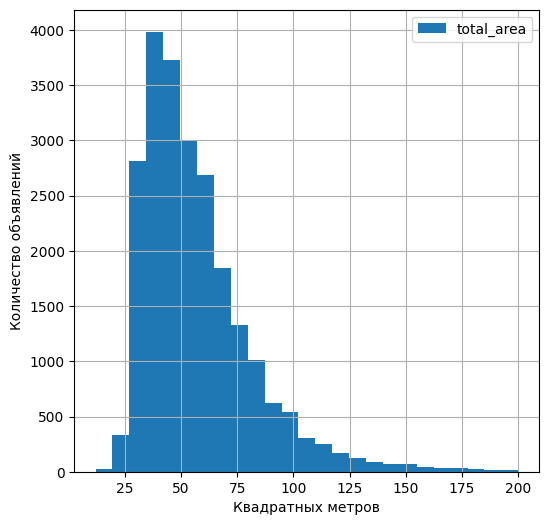

total_area
245.0    1
248.0    1
249.0    1
249.9    1
250.0    3
255.0    1
256.0    1
259.6    1
263.8    1
272.6    1
277.6    1
281.1    1
287.5    1
309.7    1
312.0    1
313.0    1
316.3    1
320.0    1
363.0    1
460.8    1
Name: last_price, dtype: int64

In [57]:
# отрисуем гистаграмму по значениям от минимального 12 кв м. до 200 кв. м.,
# где количество таких объектов максимально стремится к нулю

good_data.plot(
    kind='hist',
    y='total_area',
    figsize=(6,6),
    range=(12, 200),
    histtype='bar',
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество объявлений')
plt.xlabel('Квадратных метров')
plt.show()

# выведем 20 самых больших по площадям помещений, а также количество объявлений с такими площадями
good_data.groupby('total_area')['last_price'].count().tail(20)

1. На гистограмме видно, что большинство помещений располагаются между 20 и 100 квадратными метрами. Среднее как и медиана видна на гистограмме также отчетливо - там распологается большая часть среди этой выборки. 
2. Гистограмма показывает, что перед нами распределение скошенное вправо - с правосторонней ассиметрией. Это указывает на то, что большинство объявлений сосредоточено вокруг меньших значений `total_area`, а значение превышающие среднее встречаются всё реже.

#### Жилая площадь

In [58]:
print(good_data['living_area'].describe())
print()
print('Коэффициент корреляции Пирсона между общей площадью и жилой площадью =',good_data['living_area'].corr(good_data['total_area']).round(2))

count    23235.000000
mean        33.065706
std         17.601901
min          2.000000
25%         18.920000
50%         30.000000
75%         41.600000
max        279.600000
Name: living_area, dtype: float64

Коэффициент корреляции Пирсона между общей площадью и жилой площадью = 0.93


В столбце "жилая площадь" данные очень схожи в процентном соотношении с данными из столбца 'total_area'. Об этом говорит очень высокий коэффициент корреляции Пирсона = 0.9

В столбце "жилая площадь" среднее значение 33 близко к медианному значению 30.3, что говорит о том, что распределение похоже на нормальное, но наклонено в одну из сторон. Если среднее значение больше медианной, то распределение наклонено в правую сторону.

Стандартное отклонение высокое - 17.1, что говорит о высоком разбросе данных вокруг среднего значения (50%+ от среднего значения)

Квантильные значения находятся примерно на одном уровне, с небольшой разницей между собой - это говорит о том, что большинство всех данных находится в диапазоне между 19 и 40.5.

Максимальное значение площади сильно отличается от большинства значений, такие данные можно назвать выбросами. Мы предварительно исключили все очень дорогие помещения и работаем по обработанному срезу данных. Можем допустить, что для анализа такие помещения могут быть полезны, и убирать их не стоит.

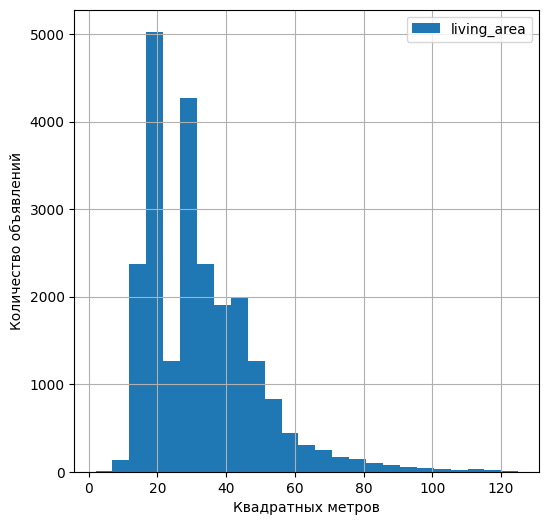

In [59]:
# отрисуем гистограмму по значениям от минимального 2 кв м. до 200 кв. м.,
# где количество таких объектов максимально стремится к нулю

good_data.plot(
    kind='hist',
    y='living_area',
    figsize=(6,6),
    range=(2, 125),
    histtype='bar',
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество объявлений')
plt.xlabel('Квадратных метров')
plt.show()

На гистограмме видно странное распределение ближе к середине - огромное количество объявлений с площадью в 20 кв. м., провал между 20 и 25, скачок на 25 кв. м., давайте рассмотрим поближе эти значения.

##### Гипотеза связи объёма жил. площади и территориальной принадлежности

In [60]:
# создадим функцию, которая будет категоризировать данные по количеству метров жил. площади
def living_groups(dataframe):
    if 10 < dataframe['living_area'] <= 15:
        return '10-15'
    elif 15 < dataframe['living_area'] <= 20:
        return '15-20'
    elif 20 < dataframe['living_area'] <= 25:
        return '20-25'
    elif 25 < dataframe['living_area'] <= 30:
        return '25-30'
    elif 30 < dataframe['living_area'] <= 35:
        return '30-35'
    else:
        return '35+'

# создадим новую колонку с категориями жилой площади в датафрейме data
good_data['living_area_category'] = good_data.apply(living_groups, axis=1)

# выведем информацию, сколько значений по каждой из категорий
print('Категория : количество\n', good_data.groupby('living_area_category')['living_area'].count().sort_index())

Категория : количество
 living_area_category
10-15    1004
15-20    5887
20-25    1414
25-30    3593
30-35    3023
35+      8314
Name: living_area, dtype: int64


Видим, что категория 10-15 самая низкая по количеству объявлений, а также значения очень близки в категории 20-25.

Давайте подробнее ознакомимся в возможных причинах такого распределения.

In [61]:
# создадим список категорий
categories = ["10-15", "15-20", "20-25", "25-30", "30-35", "35+"]

# создадим словарь для хранения данных
living_locality = {}
filtered_ll = {}

# создадим цикл, который будет проходить по каждой из категорий
# и в котором будем учитывать только те данные, значения которых больше 20

for category in categories:
    living_locality[category] = good_data.query(f'living_area_category == "{category}"').groupby('locality_name')['living_area'].count()
    filtered_ll[category] = living_locality[category][living_locality[category] > 20]

In [62]:
# создадим датафрейм, содержащий все объекты series с отфильтрованными данными
filtered_grouped = pd.DataFrame() 

for category in categories:
    filtered_grouped[category] = filtered_ll[category]

filtered_grouped.fillna(0, inplace=True)

# переведем все столбцы в тип int
for column in filtered_grouped:
    filtered_grouped[column] = filtered_grouped[column].astype(int)

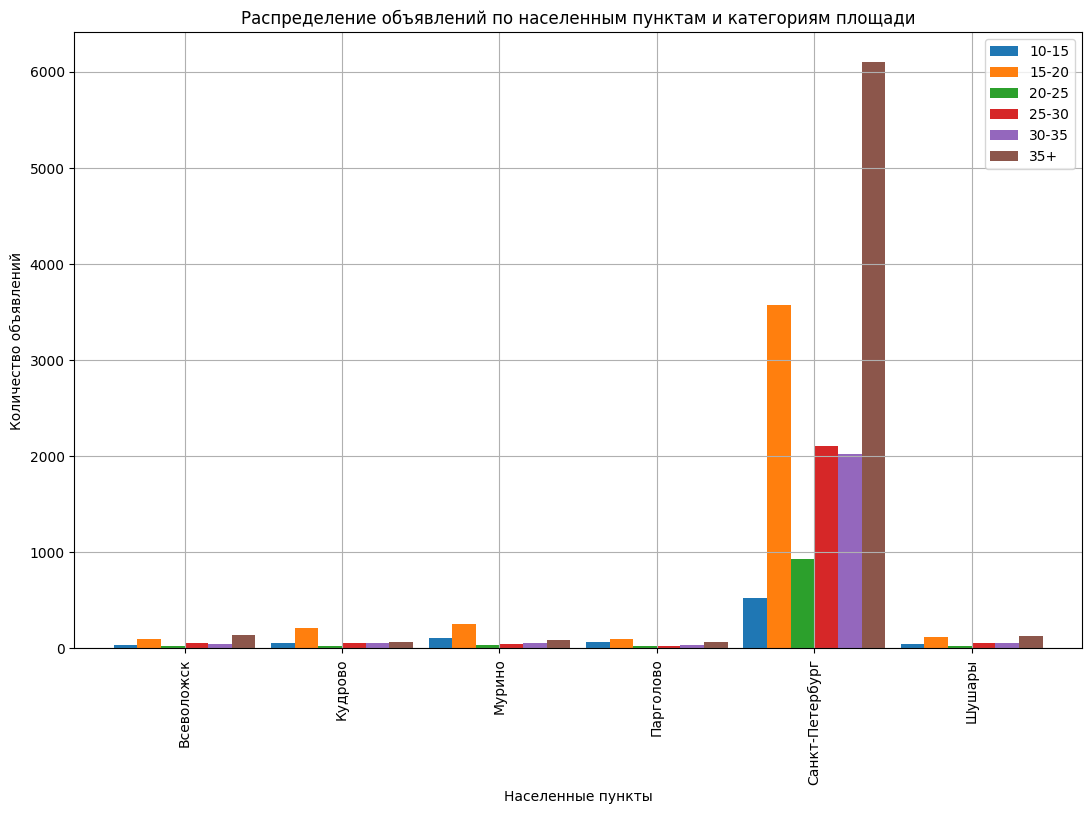

In [63]:
# создадим столбчатую диаграмму

filtered_grouped.plot(
    kind='bar',
    figsize=(13,8),
    grid=True,
    width=0.9
)
plt.title('Распределение объявлений по населенным пунктам и категориям площади')
plt.xlabel('Населенные пункты')
plt.ylabel('Количество объявлений')
plt.show()

plt.show()

Была надежда, что отличия в данных были связаны с разными населенными пунктами. 
Есть небольшая связь того, что объявления с маленькой жилой площадью 10-15 кв. м. располагаются помимо Санкт-Петербурга еще и в Кудрово, Мурино, и Парголово, возможно эти населенные пункты являются теми местами, где самое дешевое и маленькое жилье.

В таком случае давайте разберем Санкт-Петербург поближе - разделим приближенность к центру на категории и попробуем найти связь между приближенностью к центру и количеством квадратных метров жилой площади.

In [64]:
good_data['center_km'].describe()

count    17728.000000
mean        14.393727
std          8.591622
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: center_km, dtype: float64

In [65]:
# создадим функцию, которая будет категоризировать данные по приближению к центру используя выведеные квантили
# также хочу поделить 1-ый квантиль наапополам, чтобы увеличить точность
def center_groups(dataframe):
    if dataframe['center_km'] < 4.5:
        return '12.5%'
    elif dataframe['center_km'] < 9:
        return '25%'
    elif dataframe['center_km'] < 13:
        return '50%'
    elif dataframe['center_km'] < 16:
        return '75%'
    elif dataframe['center_km'] >= 16:
        return '75%-100%'
    else:
        return 'no info'
    
# создадим новую колонку с категориями жилой площади в датафрейме good_data
good_data['center_category'] = good_data.apply(center_groups, axis=1)

# выведем информацию, сколько значений по каждой из категорий
print('Категория : количество\n', good_data.groupby('center_category')['last_price'].count().sort_index())

Категория : количество
 center_category
12.5%       1440
25%         2298
50%         4083
75%         4293
75%-100%    5614
no info     5507
Name: last_price, dtype: int64


Попробуем объединить два наших датафрейма, и создадим сводную таблицу:

In [66]:
# объединение датафреймов data и filtered_grouped

data_filtered_group = pd.merge(good_data, filtered_grouped, on='locality_name')

data_filtered_group.head(10)

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,weekday,month,year,floor_type,center_km,living_area_category,center_category,10-15,15-20,20-25,25-30,30-35,35+
0,20,13000000.0,13.000,108.0,2019-03-07,3,2.70,16.0,51.00,8,True,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.37,3,3,2019,другой,16.0,35+,75%-100%,521,3577,935,2109,2019,6105
1,10,5196000.0,5.196,56.0,2015-08-20,2,2.74,5.0,34.30,4,True,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.71,3,8,2015,другой,14.0,30-35,75%,521,3577,935,2109,2019,6105
2,2,10000000.0,10.000,100.0,2018-06-19,2,3.03,14.0,32.00,13,True,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.00,1,6,2018,другой,8.0,30-35,25%,521,3577,935,2109,2019,6105
3,5,7915000.0,7.915,71.6,2019-04-18,2,2.74,24.0,41.05,22,True,False,False,18.9,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,NaN,110544.69,3,4,2019,другой,12.0,35+,50%,521,3577,935,2109,2019,6105
4,18,5400000.0,5.400,61.0,2017-02-26,3,2.50,9.0,43.60,7,True,False,False,6.5,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0,88524.59,6,2,2017,другой,15.0,35+,75%,521,3577,935,2109,2019,6105
5,5,5050000.0,5.050,39.6,2017-11-16,1,2.67,12.0,20.30,3,True,False,False,8.5,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.25,3,11,2017,другой,14.0,20-25,75%,521,3577,935,2109,2019,6105
6,16,4650000.0,4.650,39.0,2017-11-18,1,2.74,14.0,20.50,5,True,False,False,7.6,1,Санкт-Петербург,12900.0,14259.0,1,590.0,1,296.0,19.0,119230.77,5,11,2017,другой,14.0,20-25,75%,521,3577,935,2109,2019,6105
7,11,6700000.0,6.700,82.0,2017-11-23,3,3.05,5.0,55.60,1,True,False,False,9.0,0,Санкт-Петербург,22108.0,10698.0,3,420.0,0,NaN,397.0,81707.32,3,11,2017,первый,11.0,35+,50%,521,3577,935,2109,2019,6105
8,6,4180000.0,4.180,36.0,2016-09-09,1,2.74,17.0,16.50,7,True,False,False,11.0,1,Санкт-Петербург,33564.0,14616.0,0,NaN,1,859.0,571.0,116111.11,4,9,2016,другой,15.0,15-20,75%,521,3577,935,2109,2019,6105
9,8,3250000.0,3.250,31.0,2017-01-27,1,2.50,5.0,19.40,2,True,False,False,5.6,1,Санкт-Петербург,44060.0,10842.0,1,759.0,0,NaN,168.0,104838.71,4,1,2017,другой,11.0,15-20,50%,521,3577,935,2109,2019,6105


In [67]:
pivot_table = pd.pivot_table(data_filtered_group, values='total_area', index='center_category', columns='living_area_category', aggfunc=['count'])
pivot_table.columns = ['10-15', '15-20', '20-25', '25-30', '30-35', '35+']
pivot_table

,10-15,15-20,20-25,25-30,30-35,35+
center_category,,,,,,
12.5%,28,77,71,112,125,1015
25%,71,292,137,206,295,1291
50%,148,1060,270,680,534,1381
75%,116,1229,286,642,606,1414
75%-100%,268,1129,219,552,548,1180
no info,198,574,84,167,170,318


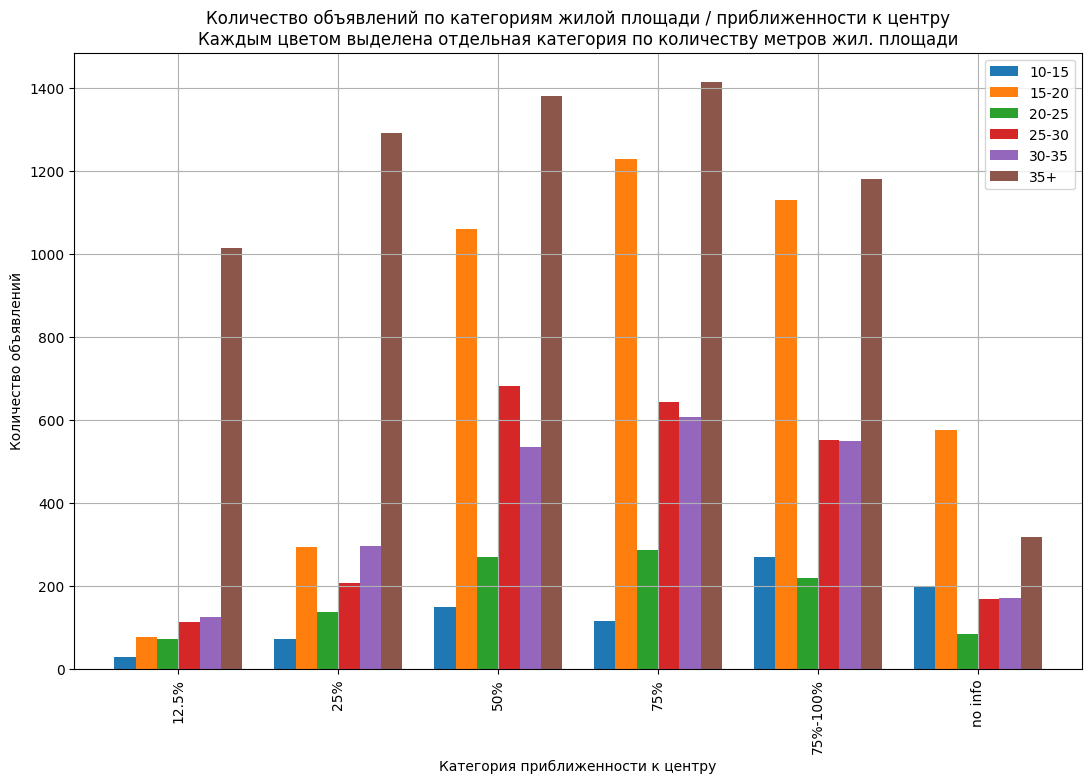

In [68]:
pivot_table.plot(
    kind='bar',
    figsize=(13,8),
    grid=True,
    width=0.8,
)
plt.title('Количество объявлений по категориям жилой площади / приближенности к центру'
          '\nКаждым цветом выделена отдельная категория по количеству метров жил. площади')
plt.xlabel('Категория приближенности к центру')
plt.ylabel('Количество объявлений')
plt.show()

##### Подведение итогов гипотезы

Главным вопросом при исследовании данных было найти причину, почему в категории 20-25 кв.м. так мало объявлений, относительно других категорий. 
Рассмотрим подробнее данные:
 1. Количество объявлений по каждой из категорий увеличивается с отдаленностью от центра, независимо от жилой площади
 2. Интересующая нас категория 20-25 кв. м. занимает примерно одинаковую часть объявлений от каждой из категории приближенности к центра, относительно всех объявлений.
 3. Категория 12.5% показывает, что при максимальной приближенности к центру, преимущественно большая часть объявлений с площадями больше чем 35+ кв м.
 4. Категория 10-15 показывает, что большинство таких объявлений, с такой низкой жилой площадью, распологаются дальше всего от центра. В первой категории приближенности их количество пропорционально очень мало
 5. Категория 15-20 показывет, что преимщуественное большинство таких объявлений находятся начиная с 50% отдаленности от центра и дальше.
 6. Категории 25-30, 30-35 жилых площадей приблизительно равны относительно каждой из категории приближенности к центру
 7. В первоначальной столбчатой гистограмме мы обнаружили, что квартиры с жилой площадью 10-15 кв. м. также иногда располагаются в Мурино, Кудрово и Парголово.

Подвести однозначный вывод аномальной разницы количества объявлений в категории 20-25 кв. м. жилой площади не получилось.

#### Площадь кухни

In [69]:
good_data['kitchen_area'].describe()

count    23235.000000
mean        10.170794
std          5.039571
min          1.300000
25%          7.000000
50%          9.000000
75%         11.670000
max        100.700000
Name: kitchen_area, dtype: float64

Среднее значение 10.3 близко к медианному значению 9.5, что говорит о том, что распределение близкое к нормальному, но имеет наклонение в одну из сторон. Если среднее значение больше медианной, то распределение наклонено в правую сторону.

Стандартное отклонение среднее - 4.8, что говорит о высоком разбросе данных вокруг среднего значения (практически 50% от среднего значения)

Квантильные значения находятся примерно на одном уровне, с небольшой разницей между собой - это говорит о том, что большинство всех данных находится в диапазоне между 7.2 и 11.3.

Максимальное значение в 100.7 означает, что в датафрейме присутствуют объявления с большими площадями помещений.

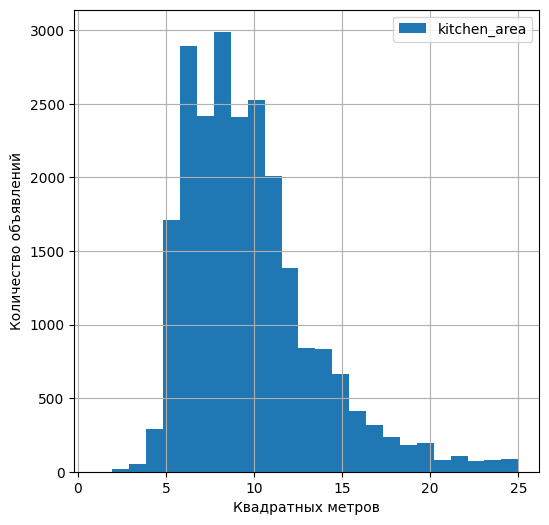

kitchen_area
46.80     1
47.00     1
48.00     2
48.30     1
49.40     1
50.00     3
50.20     1
51.00     2
53.00     2
54.20     1
55.50     1
55.70     1
56.20     1
56.29     1
58.00     1
60.00     1
64.00     2
65.00     2
70.00     1
100.70    1
Name: last_price, dtype: int64

In [70]:
# отрисуем гистаграмму по значениям от минимального 1 кв м. до 25 кв. м.

good_data.plot(
    kind='hist',
    y='kitchen_area',
    figsize=(6,6),
    range=(1, 25),
    histtype='bar',
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество объявлений')
plt.xlabel('Квадратных метров')
plt.show()

# выведем 20 самых больших по площадям кухонь, а также количество объявлений с такими площадями
good_data.groupby('kitchen_area')['last_price'].count().tail(20)

#### Цена объекта

In [71]:
good_data['price_sq_m'].describe()

count     23235.000000
mean      95738.664915
std       34342.394829
min         111.830000
25%       76049.360000
50%       94383.780000
75%      112820.510000
max      640422.350000
Name: price_sq_m, dtype: float64

Среднее значение 95,378 руб. очень близко к медианному значению 94,383 руб.. Это говорит о том, что распределение данных очень похоже на нормальное.

Стандартное отклонение ниже, чем в предыдущих столбцах - 34,342 руб., что является 35% от среднего значения.  

Квантильные значения находятся близко друг к другу, с небольшой разницей между собой - это говорит о том, что в большинстве случаев цена за 1 кв. м. составляет сумму в диапазоне от 76,049 руб. до 112,820 руб.

Максимальное значение 640,422 является достаточно высоким и может говорить о том, что такое объявление о помещении находящемся возможно в элитном районе Санкт-Петербурга.

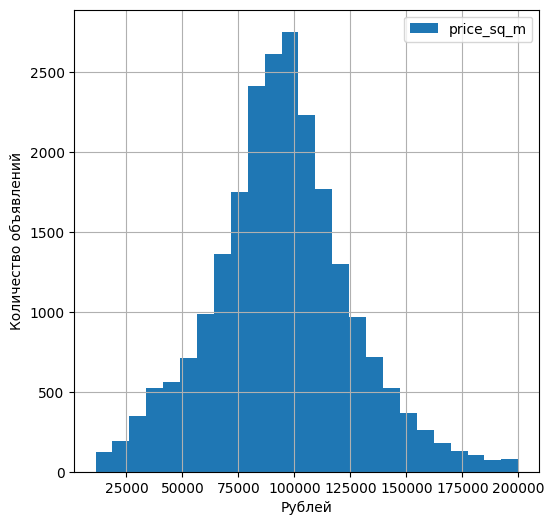

price_sq_m
288778.88    1
292307.69    1
295202.95    1
299000.00    1
303813.95    1
307262.57    1
308333.33    1
310164.24    1
312240.00    1
323943.66    1
324675.32    1
324727.27    1
333333.33    1
339805.29    1
350070.26    1
355555.56    2
387096.77    1
392354.12    1
600000.00    1
640422.35    1
Name: last_price, dtype: int64

In [72]:
# отрисуем гистограмму по значениям от минимального 11183 руб. до 200000 руб.

good_data.plot(
    kind='hist',
    y='price_sq_m',
    figsize=(6,6),
    range=(11183, 200000),
    histtype='bar',
    bins=25,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество объявлений')
plt.xlabel('Рублей')
plt.show()

# выведем 20 самых дорогих стоимостей в рублях за квадратный метр площади, а также количество объявлений с такими ценами
good_data.groupby('price_sq_m')['last_price'].count().tail(20)

Гистограмма цены за квадратный метр говорит нам о том, что распределение в выборке до аномальных значений является нормальным.
Рассмотрим стоимости за 1 кв. м. самых дорогих объектов - суммы начинаются от 280 тысяч руб. за 1 кв. м и до 640 тысяч руб. за 1 кв. м. 

Можем предположить, что в элитных районах Санкт-Петербурга цена на квадратный метр действительно высока, относительно других районов и населенных пунктов.

#### Количество комнат

In [73]:
good_data['rooms'].describe()

count    23235.000000
mean         2.028233
std          1.010266
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         14.000000
Name: rooms, dtype: float64

Данные нам говорят о том, что в среднем в квартире всего 2 комнаты. Самые распространенные случаи - когда в квартире находятся 1, 2 или 3 комнаты. 

Жилье, в котором находится больше чем 3 комнаты редки. Вероятно в объявлениях есть и помещения под какие-либо центры, либо большие дома, где количество комнат может дойти до 14.

In [74]:
good_data.groupby('rooms')['last_price'].count().tail(20)

rooms
0      196
1     8040
2     7904
3     5664
4     1070
5      242
6       71
7       32
8        7
9        5
10       2
11       1
14       1
Name: last_price, dtype: int64

#### Высота потолков

In [75]:
good_data['ceiling_height'].describe()

count    23235.000000
mean         2.705462
std          0.192117
min          1.000000
25%          2.590000
50%          2.700000
75%          2.740000
max          3.980000
Name: ceiling_height, dtype: float64

In [76]:
good_data.groupby('ceiling_height')['last_price'].count().head(20)

ceiling_height
1.00       1
1.20       1
1.75       1
2.00      12
2.20       1
2.25       1
2.26       1
2.30       4
2.34       1
2.40      24
2.43       1
2.45      15
2.46       2
2.47       3
2.48       9
2.49       1
2.50    3556
2.51      41
2.52     133
2.53     156
Name: last_price, dtype: int64

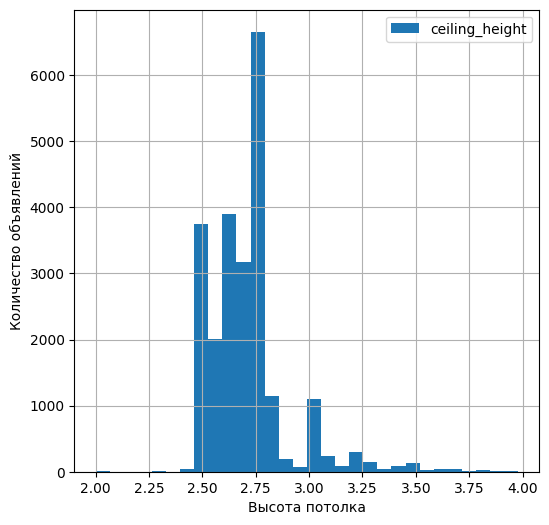

In [77]:
# отрисуем гистограмму по высоте потолка

good_data.plot(
    kind='hist',
    y='ceiling_height',
    figsize=(6,6),
    range=(2, 3.98),
    histtype='bar',
    bins=30,
    grid=True,
    linewidth=5,
)
plt.ylabel('Количество объявлений')
plt.xlabel('Высота потолка')
plt.show()

Среднее значение 2.70 метра очень близко к медианному значению 2.70 метра. Это говорит о том, что распределение данных очень похоже на нормальное.

Стандартное отклонение ниже, чем в предыдущих столбцах - 0.19 метра, что является около 7% от среднего значения. Это говорит о том, что данные имеют относительно низкий уровень изменчивости.

Квантильные значения находятся близко друг к другу, с небольшой разницей между собой - это говорит о том, что в большинстве случаев высота потолков составляет от 2.59 метра до 2.74 метров.

Максимальное значение 3.98 метра является достаточно высоким и может говорить о том, что помещения с такими высокими потолками могут находиться в элитных районах Санкт-Петербурга и быть достаточно близкими к центру.

In [78]:
print('Коэффициент корреляции Пирсона между высотой потолков и близости к центру ='
      ,good_data['center_km'].corr(good_data['ceiling_height']).round(2))

Коэффициент корреляции Пирсона между высотой потолков и близости к центру = -0.33


Как мы видим, есть небольшая отрицательная корреляция между этими двумя столбцами. Вероятно есть причинно-следственная связь между этими двумя значениями. Попробуем визуализировать эти данные с помощью диаграммы рассеяния.

Text(0.5, 0, 'Приближенность к центру города (где 0 - ближе всего к центру)')

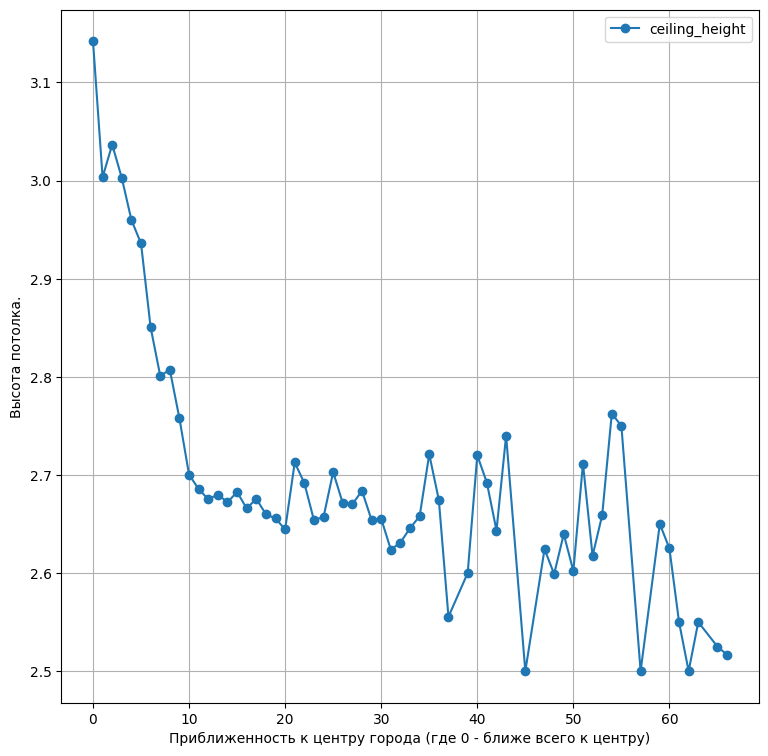

In [79]:
# визуализируем корреляцию близости к центру города с высотой потолка

good_data.pivot_table(index='center_km', values='ceiling_height').plot(
    grid=True,
    style='-o',
    figsize=(9,9)
)
plt.ylabel('Высота потолка.')
plt.xlabel('Приближенность к центру города (где 0 - ближе всего к центру)')

In [80]:
good_data.groupby('center_category')['ceiling_height'].mean()

center_category
12.5%       2.991257
25%         2.862981
50%         2.694443
75%         2.678584
75%-100%    2.664077
no info     2.636312
Name: ceiling_height, dtype: float64

Действительно, можно утверждать, что чем ближе помещение находится к центру города, тем выше потолки.

#### Тип этажа квартиры

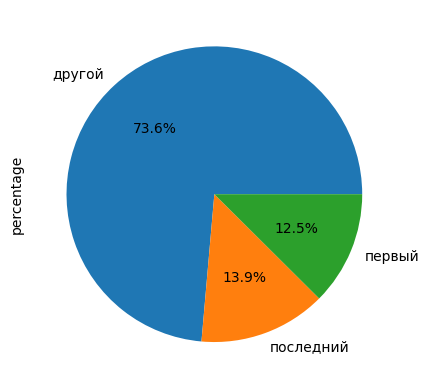

In [81]:
floor_data = good_data['floor_type'].value_counts().reset_index()
floor_data['percentage'] = (floor_data['floor_type'] / floor_data['floor_type'].sum() * 100).round(2)

floor_data.set_index('index')['percentage'].plot(
    kind='pie' ,
    autopct='%1.1f%%'
)

plt.show()

В 12.5% случаев помещения располагаются на первых этажах здания.

В 13.9%  случаев помещения располагаются на последних этажах здания.

И в большинстве случаев, а это 73.6%, в объявлениях указаны объекты, находящиеся между крайними этажами.

#### Общее количество этажей в доме

In [82]:
good_data['floors_total'].describe()

count    23150.000000
mean        10.722894
std          6.625148
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Информация говорит нам о том, что в объявлениях которые мы рассматриваем, объекты находятся в различных домах. Бывают и одноэтажные здания, возможно это простые дома, бывают и очень высокие здания, по типу случая с максимальным в 60 этажей.

Но в большинстве случаев помещения располагаются в домах от 5-ти этажных до 16-ти этажных.

#### Расстояние до центра города

In [83]:
good_data['center_km'].describe()

count    17728.000000
mean        14.393727
std          8.591622
min          0.000000
25%         10.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: center_km, dtype: float64

В тех случаях, где указан параметр отдаленности от центра, можно узнать такую информацию:
 - Большинство помещений находятся в пределах от 10 км. до 16 км. от центра
 - Какие-то помещения находятся в САМОМ центре города. Такая информация вызывает подозрение на ошибки в данных.
 - Самое далеко от центра помещение выставленное на продажу располагается в 66 км. от центра города

In [84]:
# рассмотрим объявления со странными данными
good_data.query('center_km >= 0 & center_km < 1')

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,weekday,month,year,floor_type,center_km,living_area_category,center_category
1152,1,5800000.0,5.80,33.6,2016-03-10,1,3.70,7.0,22.80,4,False,False,False,6.60,0,Санкт-Петербург,21632.0,208.0,3,304.0,3,503.0,167.0,172619.05,3,3,2016,другой,0.0,20-25,12.5%
1891,18,9590000.0,9.59,108.0,2017-05-23,2,3.30,5.0,59.00,2,False,False,False,11.00,0,Санкт-Петербург,21908.0,287.0,3,359.0,3,290.0,69.0,88796.30,1,5,2017,другой,0.0,35+,12.5%
2550,20,7200000.0,7.20,80.0,2017-08-24,3,2.80,4.0,43.00,1,True,False,False,8.00,0,Санкт-Петербург,21832.0,399.0,3,415.0,2,516.0,11.0,90000.00,3,8,2017,первый,0.0,35+,12.5%
2926,2,5300000.0,5.30,49.0,2016-11-09,3,2.74,3.0,30.00,3,True,False,False,7.00,0,Санкт-Петербург,21919.0,467.0,2,256.0,3,305.0,232.0,108163.27,2,11,2016,последний,0.0,25-30,12.5%
3718,12,6900000.0,6.90,47.6,2015-07-22,2,2.74,5.0,28.20,5,True,False,False,8.20,0,Санкт-Петербург,22074.0,472.0,3,319.0,3,142.0,398.0,144957.98,2,7,2015,последний,0.0,25-30,12.5%
5409,8,13900000.0,13.90,185.0,2019-03-30,5,2.74,3.0,106.06,2,True,False,False,12.00,0,Санкт-Петербург,21919.0,467.0,2,256.0,3,305.0,NaN,75135.14,5,3,2019,другой,0.0,35+,12.5%
8075,10,13500000.0,13.50,96.9,2018-08-06,3,3.20,7.0,67.30,3,True,False,False,14.80,0,Санкт-Петербург,21982.0,387.0,3,138.0,2,657.0,14.0,139318.89,0,8,2018,другой,0.0,35+,12.5%
8442,7,10990000.0,10.99,100.0,2015-12-16,3,3.90,5.0,37.80,3,True,False,False,11.60,0,Санкт-Петербург,21818.0,215.0,3,229.0,2,511.0,265.0,109900.00,2,12,2015,другой,0.0,35+,12.5%
8504,15,13500000.0,13.50,98.0,2017-12-19,3,3.50,5.0,46.00,3,True,False,False,22.00,0,Санкт-Петербург,21369.0,376.0,3,541.0,3,222.0,35.0,137755.10,1,12,2017,другой,0.0,35+,12.5%
9303,3,8000000.0,8.00,106.0,2018-07-26,3,3.40,4.0,60.77,1,True,False,False,18.86,0,Санкт-Петербург,21653.0,410.0,3,591.0,2,38.0,60.0,75471.70,3,7,2018,первый,0.0,35+,12.5%


Таких строк всего 14. Предполагаю, что информация в этих строках неверная, и не могут находиться столько одновременно помещений, с такой невероятной точностью в самом центре города. Заменим эти значения на медианные по столбцу.

In [85]:
good_data.loc[(good_data['center_km'] == 0), 'center_km'] = good_data['center_km'].mean()

In [86]:
# проверим на удаление данных
good_data.query('center_km >= 0 & center_km < 1')

,total_images,last_price,last_price_mil,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_sq_m,weekday,month,year,floor_type,center_km,living_area_category,center_category


#### Расстояние до ближайшего парка

In [87]:
good_data['parks_nearest'].describe()

count    7750.000000
mean      494.109935
std       343.011048
min         1.000000
25%       290.000000
50%       456.000000
75%       614.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [88]:
print(good_data.query('parks_nearest >= 1 and parks_nearest <= 100').groupby('parks_nearest')['last_price'].count().head(30))
print('Всего объектов с расстоянием от 1 до 100 метров близости к парку:', good_data.query('parks_nearest >= 1 and parks_nearest <= 100').groupby('parks_nearest')['last_price'].count().sum())

parks_nearest
1.0      1
3.0      1
4.0      1
7.0      1
9.0      2
10.0     7
11.0     5
12.0     1
13.0     6
14.0     1
15.0     5
16.0     5
17.0     6
18.0     8
19.0     8
20.0     9
21.0     4
22.0     3
23.0     3
24.0    17
27.0     1
28.0     1
30.0     3
32.0     1
33.0     3
34.0     3
35.0     3
36.0    10
37.0     8
38.0    13
Name: last_price, dtype: int64
Всего объектов с расстоянием от 1 до 100 метров близости к парку: 407


Расстояние в 1 метр до ближайшего парка пугает. Не могут же продаваться объекты прямо в парке? Также видим, что объектов с приближенностью к парку в расстояние менее 100 метров аж 407.

Предполагаю, что проблема связана с указанием конкретных точек, где считается, что находится центр конкретного парка.
Такие данные можно оставить как есть.

В остальном показатели выглядят в норме, если брать во внимание то, что не ко все строкам автоматически собраны данные. 
- Максимально отдаленный от парка объект в радиусе 3.1 км.
- В среднем объекты находятся в ~0.5 км от парков
- Большинство объектов располагаются в зоне между 290 метрами и 614 метрами

Думаю при сборе информации о приближенности к паркам было установлено какое-то ограничение в метрах, и если это значение превосходило, то данные просто не собирались.

### Исследование по скорости продажи объектов

Для начала построим гистограмму, которая покажет нам данные по количеству дней затраченных на продажу.

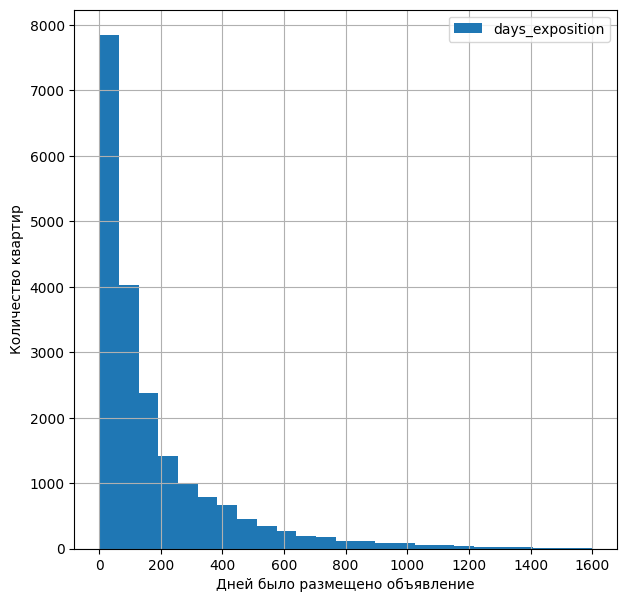

In [89]:
good_data.plot(
    kind='hist',
    histtype='bar',
    y='days_exposition',
    grid=True,
    figsize=(7,7),
    range=(0, 1600),
    bins=25,
)
plt.ylabel('Количество квартир')
plt.xlabel('Дней было размещено объявление')
plt.show()

In [90]:
good_data['days_exposition'].describe()

count    20177.000000
mean       178.770878
std        217.423838
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Давайте ближе рассмотрим данные между минимальным значением и третьим квантилем:

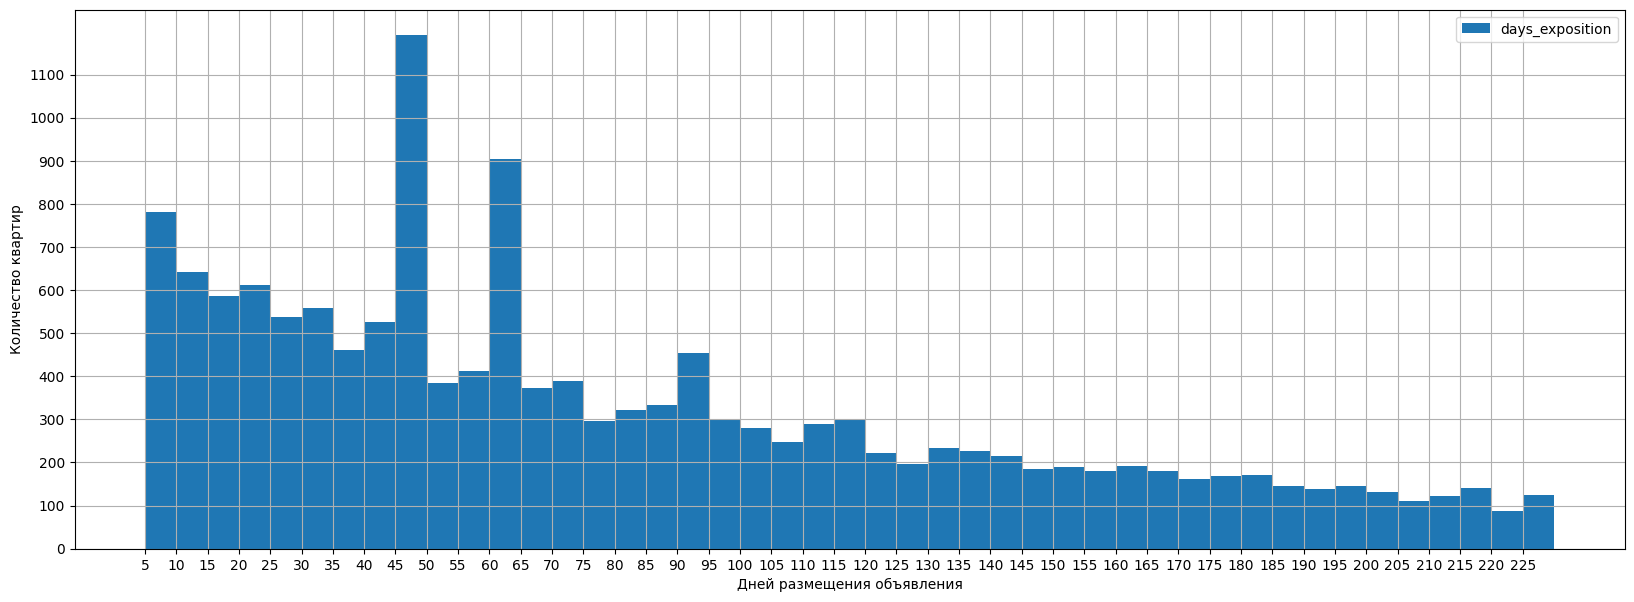

In [91]:
good_data.plot(
    kind='hist',
    histtype='bar',
    y='days_exposition',
    grid=True,
    figsize=(20,7),
    range=(5, 230),
    bins=45,
)
plt.ylabel('Количество квартир')
plt.xlabel('Дней размещения объявления')
# добавим деления на оси x, чтобы были лучше видны аномальные значения
plt.xticks(range(5, 230, 5))
plt.yticks(range(0, 1200, 100))
plt.show()

На приближенной гистограмме видны сразу несколько значений, которые выбиваются из всех:
 1. Почти 800 объявлений было закрыто спустя 5 дней с момента открытия объявления. На это могут быть две причины:
  - Объекты были сняты владельцами по различным причинам (передумали продавать, нужно изменить данные, необходимо дождаться другого срока, решили сделать ремонт и т.д.)
  - Объекты были настолько хороши, что продажа произошла настолько быстро.
 2. Значения в 45, 60 и 90 дней выделяются среди прочих - такие ровные даты могут говорить о том, что для какого-то рода объявлений существуют ограничения на нахождение объявлений в сервисе. Возможно это связано с уровнем аккаунта, или если объявления платные - какой тип объявления. Вероятно, такие ограничения вступили в силу не с момента появления сервиса, а спустя какое-то время, тем самым не все объявления из истории записей попадают под это ограничение.
 
Сначала проверим гипотезу, что ограничения появились не с самого начала сбора данных, а лишь в каком-то определенном году.

После этого выведем в отдельный датафрейм объявления, без значений в 45, 60 и 90 дней. 

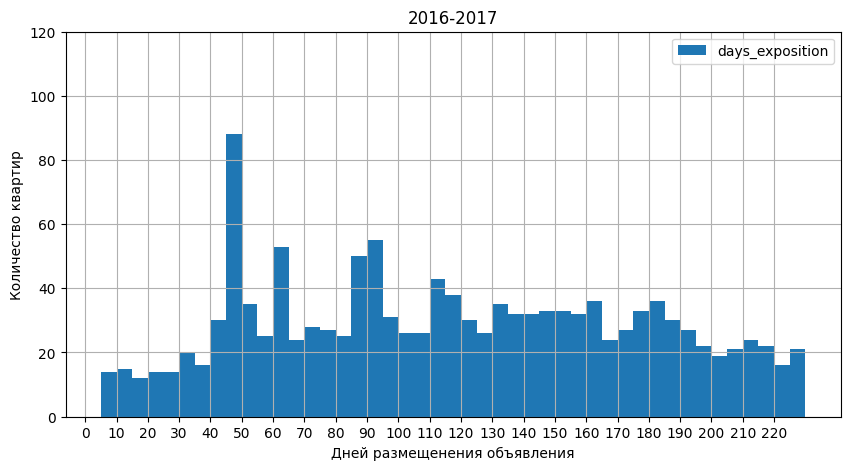

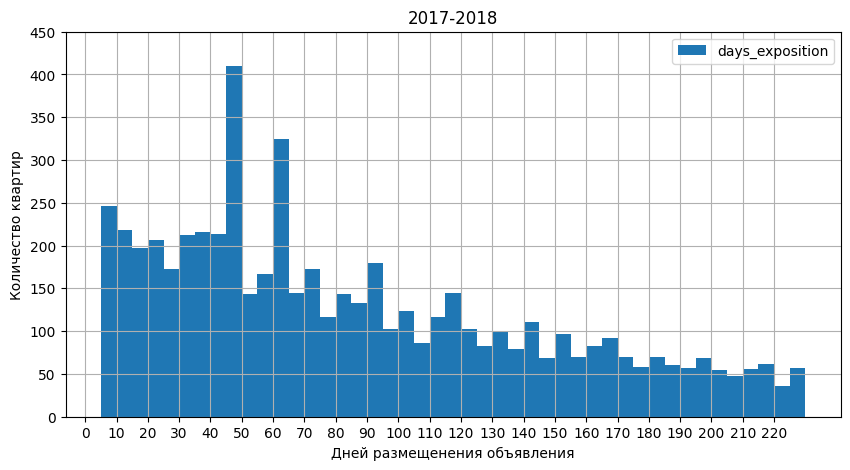

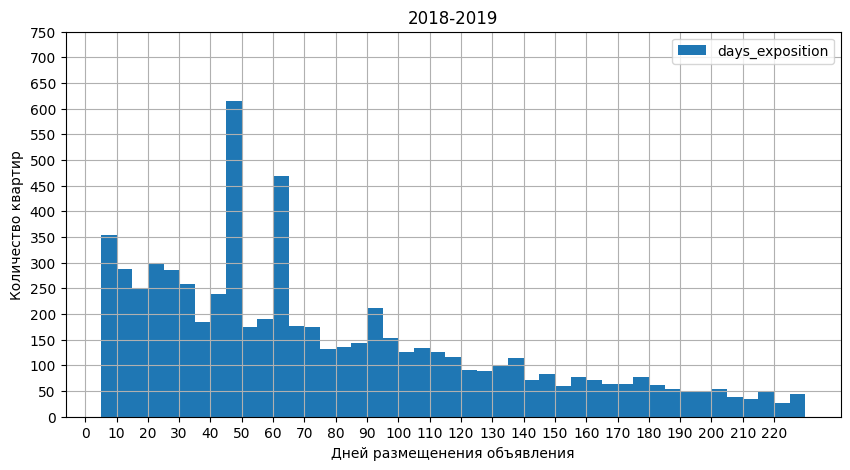

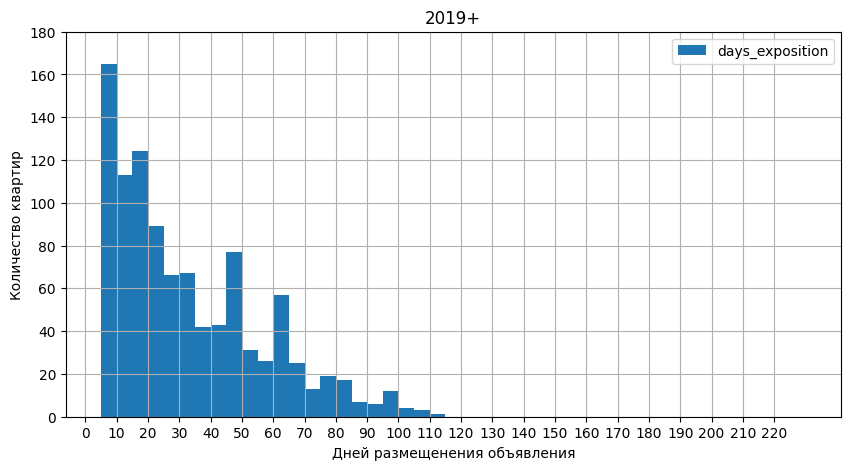

In [92]:
exposition = ['first_day_exposition > 2016 & first_day_exposition < 2017', 
              'first_day_exposition > 2017 & first_day_exposition < 2018',
              'first_day_exposition > 2018 & first_day_exposition < 2019',
              'first_day_exposition > 2019']
yticks = {0: [0, 140, 20], 
          1: [0, 500, 50], 
          2: [0, 800, 50], 
          3: [0, 200, 20]}
years = ['2016-2017', '2017-2018', '2018-2019', '2019+']

for i in range(0, 4):
    good_data.query(exposition[i]).plot(
    kind='hist',
    histtype='bar',
    y='days_exposition',
    grid=True,
    figsize=(10,5),
    range=(5, 230),
    bins=45)
    plt.ylabel('Количество квартир')
    plt.xlabel('Дней размещенения объявления')
    plt.title(years[i])
    plt.xticks(range(0, 230, 10))
    plt.yticks(range(yticks[i][0], yticks[i][1], yticks[i][2]))
    plt.show()
    i+=1

Гипотеза с появлением услуги в определенный момент времени не оправдалась. В каждый из проверенных годов есть завышенные от остальных значения в это количество дней.

В таком случае предполагаю, что на это есть причина, в виде двух типов объявлений:
 1. Имеющие ограничения в 45, 60 и 90 дней
 2. Не имеющие ограничений по времени выставления объявлений - возможно за дополнительную плату.

---

**Обновленные данные без значения в 45, 60, 90 дней**

---

In [93]:
# для начала создадим датафрейм, приведем столбец в int, предварительно удалив все строки с пропущенными значениями
good_old_data = good_data.dropna(subset=['days_exposition']).reset_index(drop=True)
good_old_data['days_exposition'] = good_old_data['days_exposition'].astype('int')
good_old_data = good_old_data.query('days_exposition != 45 & days_exposition != 60 & days_exposition != 90')

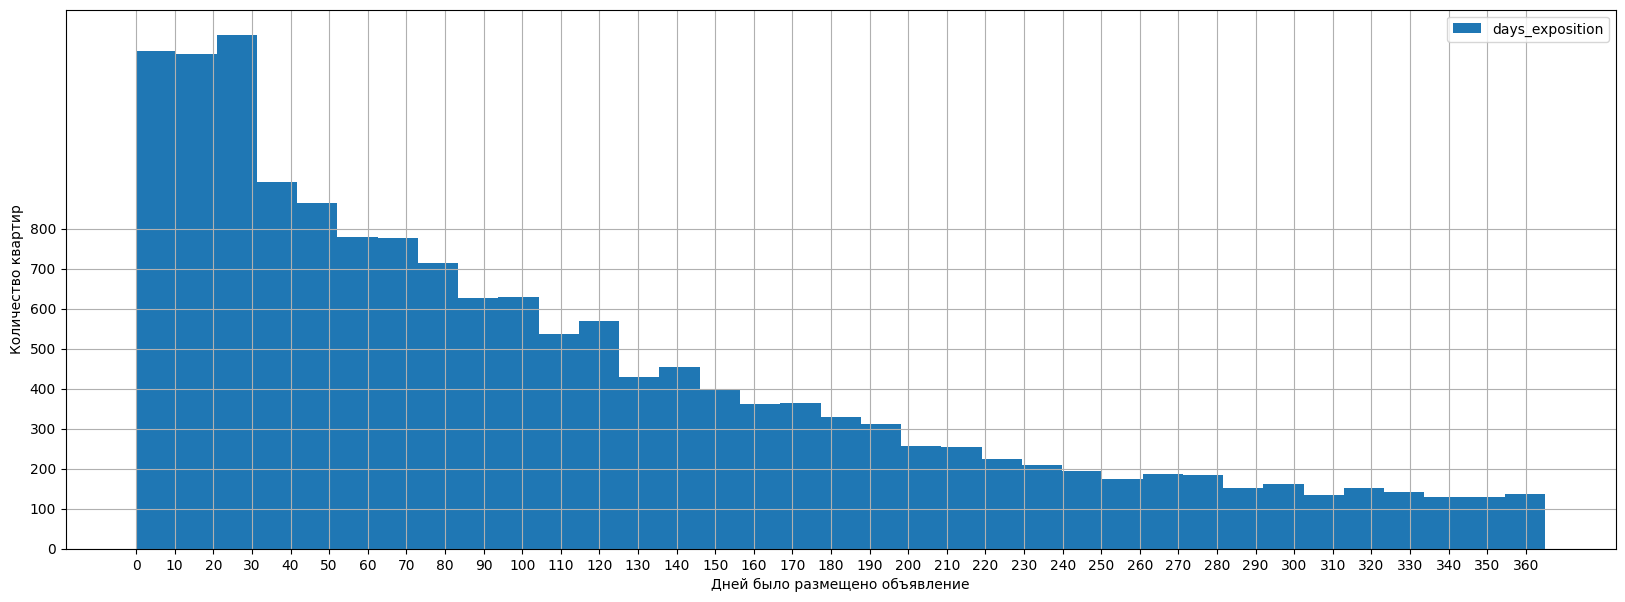

In [94]:
good_old_data.plot(
    kind='hist',
    histtype='bar',
    y='days_exposition',
    grid=True,
    figsize=(20,7),
    range=(0, 365),
    bins=35,
)
plt.ylabel('Количество квартир')
plt.xlabel('Дней было размещено объявление')
plt.xticks(range(0, 365, 10))
plt.yticks(range(0, 900, 100))
plt.show()

In [95]:
good_old_data['days_exposition'].describe()

count    18573.000000
mean       189.436009
std        223.399334
min          1.000000
25%         41.000000
50%        109.000000
75%        249.000000
max       1580.000000
Name: days_exposition, dtype: float64

---
**В оригинальных данных**:
 - В среднем объекты продавались за 178 дней, тогда как медиана продажи составляла 94 дня.
 - Большинство объектов продавались в период с 45 по 228 дней.

**В обновленных данных**:

 - В среднем объекты продавались за 190 дней, тогда как медиана продажи составляла 109 дней.
 - Большинство объектов продавались в период с 41 по 249 дней.

**В общем**:
 - Есть случаи, когда объекты продавались до 1580 дней.  В гонке побеждает черепаха, главное - продать объект!
 - Есть случаи продажи объектов за 1 день - но как мы уже предположили ранее, это могли быть снятие объявлений самими продавцами.
 - Можно назвать быстрыми продажи объектов, обобщив данные из двух датафреймов, если объект продан раньше чем за 43 дня.
 - Можно назвать продажи необычно долгими те, которые проданы более чем спустя 240 дней

### Исследование факторов влияния на стоимость объекта

Давайте построим обновленную тепловую карту с уже обработанными данными, исключающими дубликаты, пропуски и аномальные значения

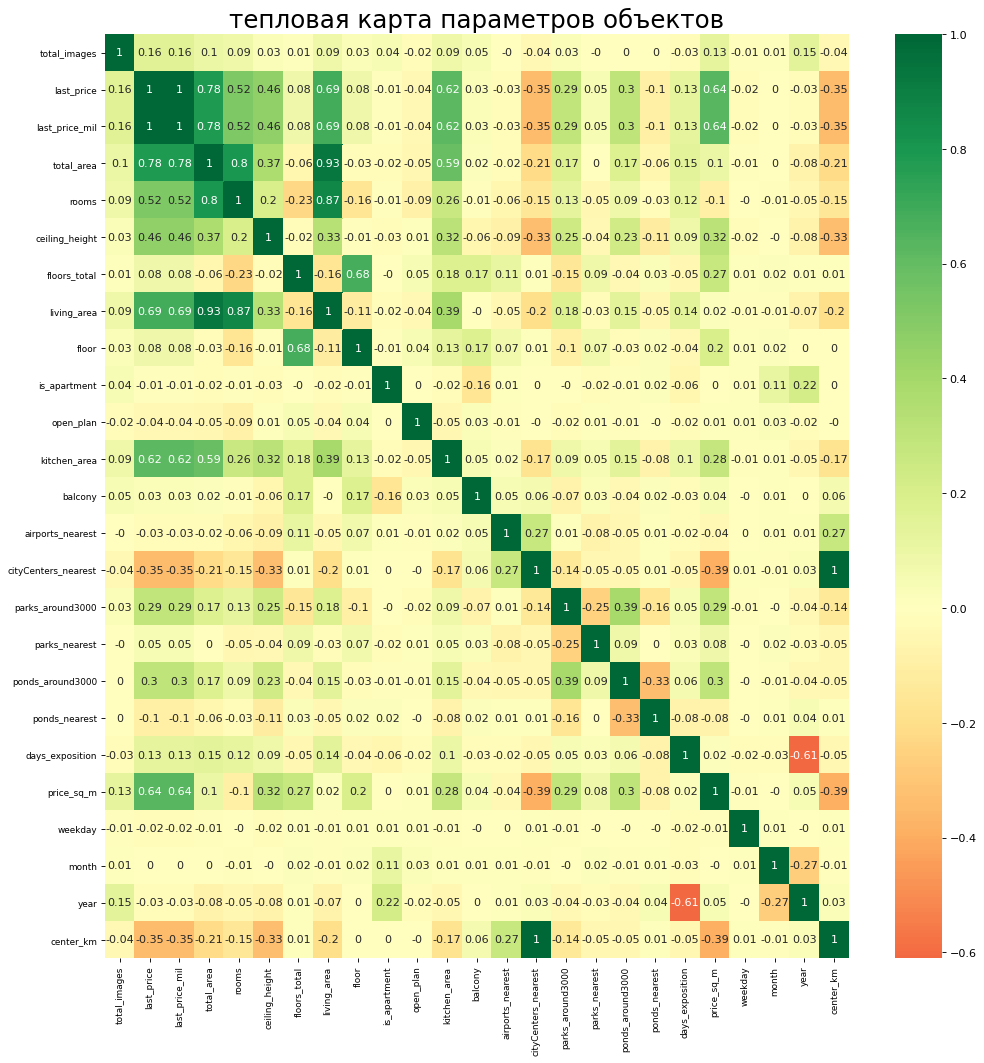

In [96]:
# выведем тепловую карту корелляции столбцов между собой


plt.figure(figsize=(15,15), dpi= 80)
sns.heatmap(np.round(good_data.corr(), 2), xticklabels=good_data.corr().columns, yticklabels=good_data.corr().columns, cmap='RdYlGn', center=0, annot=True)
plt.title('тепловая карта параметров объектов', fontsize=22)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Выведем все корреляции к `last_price_mil`, значения которых более чем абсолютные значения 0.25

In [97]:
print('Коэффициент корреляции Пирсона между столбцами:')
for column in good_data.columns:
    try:
        if abs(good_data[column].corr(good_data['last_price_mil']).round(2)) >= 0.25:
            print(f"'{column}' и 'last_price_mil': {good_data[column].corr(good_data['last_price_mil']).round(2)}")
    except:
        pass

Коэффициент корреляции Пирсона между столбцами:
'last_price' и 'last_price_mil': 1.0
'last_price_mil' и 'last_price_mil': 1.0
'total_area' и 'last_price_mil': 0.78
'rooms' и 'last_price_mil': 0.52
'ceiling_height' и 'last_price_mil': 0.46
'living_area' и 'last_price_mil': 0.69
'kitchen_area' и 'last_price_mil': 0.62
'cityCenters_nearest' и 'last_price_mil': -0.35
'parks_around3000' и 'last_price_mil': 0.29
'ponds_around3000' и 'last_price_mil': 0.3
'price_sq_m' и 'last_price_mil': 0.64
'center_km' и 'last_price_mil': -0.35


Также хочу отдельно сравнить стоимость за квадратный метр и приближенность к центру, вместо общей цены к приближенности к центру.

Давайте построим графики, на которых покажем корреляции:

---
####  last_price_mil : total_area

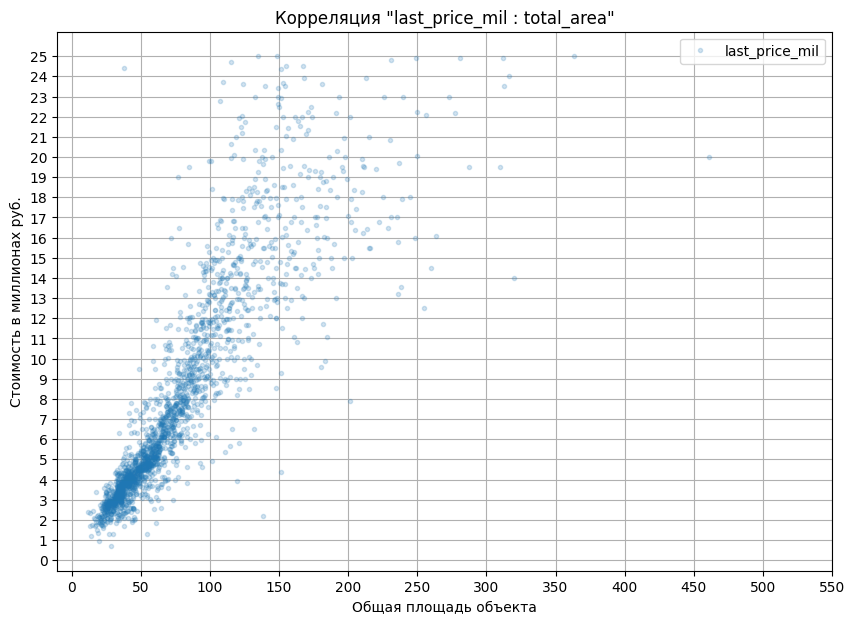

Коэффициент корреляции Пирсона между площадью объекта и и ценой объекта: 0.78


In [98]:
# общая площадь объекта и цена
total_area_price = good_data.pivot_table(
    index='total_area', 
    values='last_price_mil', 
)
total_area_price.plot(
    grid=True, 
    style='.', 
    figsize=(10, 7),
    alpha=0.2,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Общая площадь объекта')
plt.title('Корреляция "last_price_mil : total_area"')
plt.yticks(range(0, 26, 1))
plt.xticks(range(0, 600, 50))

plt.show()
print('Коэффициент корреляции Пирсона между площадью объекта и и ценой объекта:',
      good_data['total_area'].corr(good_data['last_price_mil']).round(2))

**Вывод**: 

Корреляция между общей площадью объекта и его стоимостью составляет 0.78, что указывают на высочайшую прямую связь.
Это означает, что чем больше выставляемый на продажу объект, тем выше его стоимость. Также, как мы видим на графике, количество объявлений со стоимостью продажи объектов начиная от 10 миллионов рублей значительно сокращается, и большинство самых дорогих объектов имеют площадь от ~140 кв. м.
___

#### last_price_mil : rooms

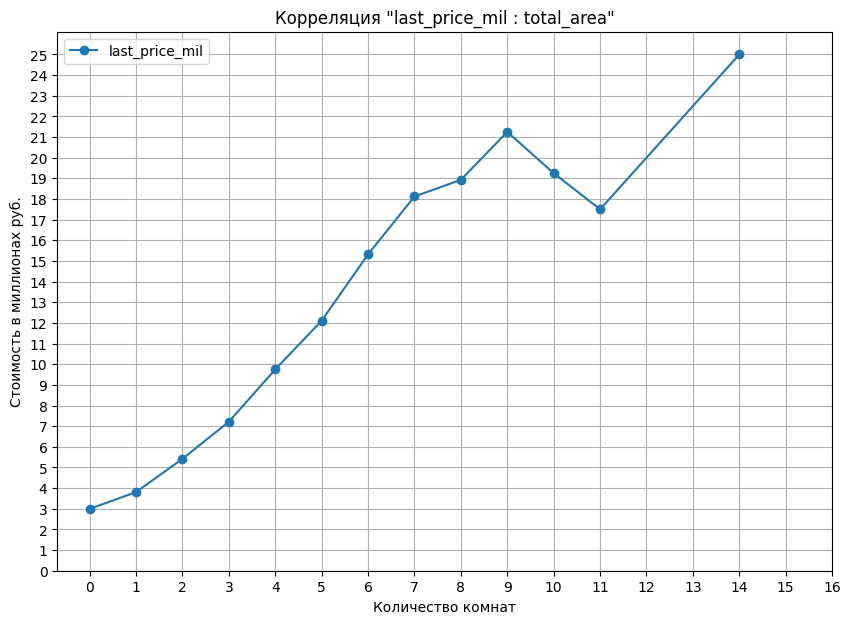

Коэффициент корреляции Пирсона между количеством комнат и ценой объекта: 0.52


,count,mean,ratio
rooms,,,
0,196,2.992508,0.844
1,8040,3.807035,34.603
2,7904,5.416721,34.018
3,5664,7.213634,24.377
4,1070,9.747193,4.605
5,242,12.105428,1.042
6,71,15.318701,0.306
7,32,18.121563,0.138
8,7,18.927143,0.030


In [99]:
# количество комнат и цена
rooms_price = good_data.pivot_table(
    index='rooms', 
    values='last_price_mil', 
    aggfunc=['count', 'mean']
)
rooms_price.plot(
    y='mean',
    grid=True, 
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Количество комнат')
plt.title('Корреляция "last_price_mil : total_area"')
plt.xticks(range(0, 17, 1))
plt.yticks(range(0, 26, 1))

plt.show()
print('Коэффициент корреляции Пирсона между количеством комнат и ценой объекта:',
      good_data['rooms'].corr(good_data['last_price_mil']).round(2))
rooms_price['ratio'] = (rooms_price['count'] / rooms_price['count'].sum() * 100).round(3)
rooms_price.columns = ['count', 'mean', 'ratio']
rooms_price

**Вывод**: 

Корреляция между количеством комнат и ценой объекта составляет 0.52, это говорит об умеренной прямой связи между ними. Очевидно, чем больше комнат в объекте, тем выше его стоимость, поскольку большее количество комнат обычно связано с большей общей площадью. Также большее количество комнат может отражать большую функциональность и привлекательность объекта для покупателей. 

Обратим внимание на факт, что большинство объявлений имеют 1, 2, 3 и даже 4 комнаты. Такие квартиры стоят от 3.8 милл. руб. до 9.7 милл. руб. в среднем. Тогда как квартиры с 5 и больше комнатами стоят уже десятки миллионов рублей.


___

#### last_price_mil : ceiling_height

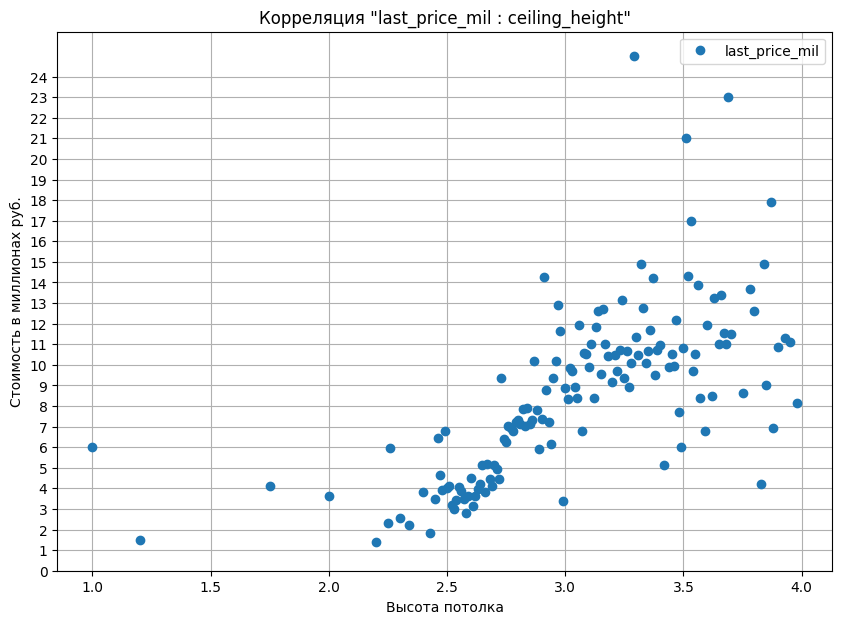

Коэффициент корреляции Пирсона между высотой потолка и ценой объекта: 0.46


In [100]:
# высота потолка и цена
good_data.pivot_table(
    index='ceiling_height', 
    values='last_price_mil', 
).plot(
    grid=True, 
    style='o', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Высота потолка')
plt.title('Корреляция "last_price_mil : ceiling_height"')
plt.yticks(range(0, 25, 1))
plt.show()
print('Коэффициент корреляции Пирсона между высотой потолка и ценой объекта:',
      good_data['ceiling_height'].corr(good_data['last_price_mil']).round(2))

**Вывод**: 

Корреляция между высотой потолков и ценой объекта составляет 0.46, что указывает на умеренную прямую связь. Это может говорить о том, что объекты с более высокими потолками зачастую стоят дороже. Высокие потолки могут делать помещения более просторными и светлыми, что является привлекательным фактором для многих покупателей. Также Санкт-Петербург славится высокими потолками в зданиях, что видно по графику (потолки порой достигают высоту в 4 метра!).
___

#### last_price_mil : living_area

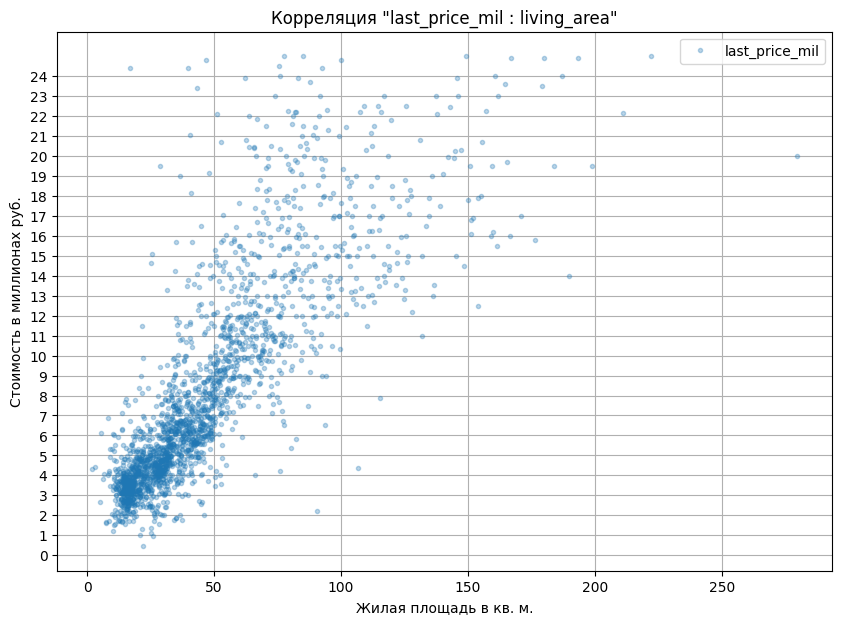

Коэффициент корреляции Пирсона между жилой площадью и ценой объекта: 0.69


In [101]:
# жилая площадь и цена
good_data.pivot_table(
    index='living_area', 
    values='last_price_mil', 
).plot(
    grid=True, 
    style='.', 
    figsize=(10, 7),
    alpha=0.3,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Жилая площадь в кв. м.')
plt.title('Корреляция "last_price_mil : living_area"')
plt.yticks(range(0, 25, 1))
plt.show()
print('Коэффициент корреляции Пирсона между жилой площадью и ценой объекта:',
      good_data['living_area'].corr(good_data['last_price_mil']).round(2))

**Вывод**: 

Корреляция между жилой площадью и последней ценой составляет 0.65, что указывает на сильную прямую связь. Это означает, что чем больше жилая площадь объекта, тем выше его стоимость. Это вполне ожидаемо, поскольку жилая площадь напрямую влияет на функциональность и комфорт объекта.
___

#### last_price_mil : kitchen_area

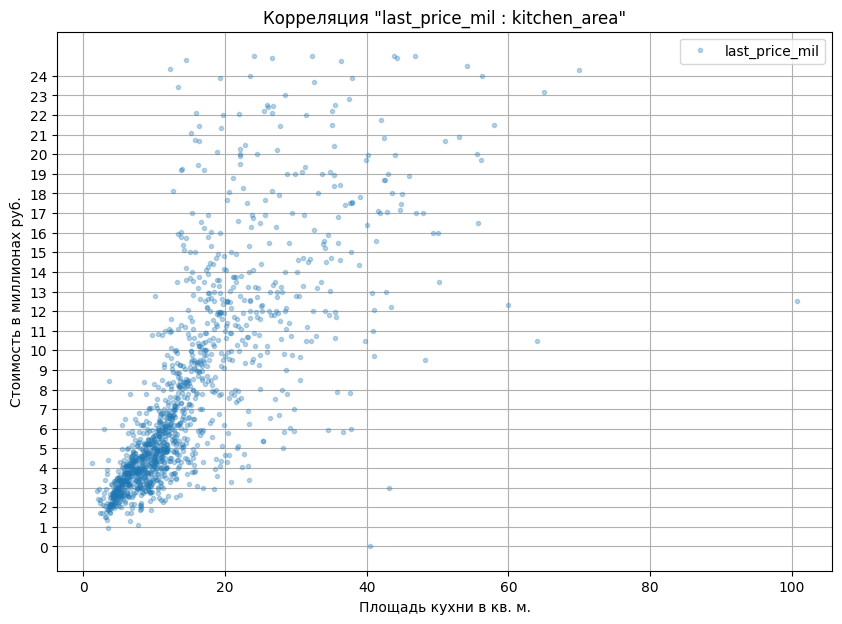

Коэффициент корреляции Пирсона между площадью кухни и ценой объекта: 0.62


In [102]:
# площадь кухни и цена
good_data.pivot_table(
    index='kitchen_area', 
    values='last_price_mil', 
).plot(
    grid=True, 
    style='.', 
    figsize=(10, 7),
    alpha=0.3,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Площадь кухни в кв. м.')
plt.title('Корреляция "last_price_mil : kitchen_area"')
plt.yticks(range(0, 25, 1))
plt.show()
print('Коэффициент корреляции Пирсона между площадью кухни и ценой объекта:',
      good_data['kitchen_area'].corr(good_data['last_price_mil']).round(2))

**Вывод**: 

Корреляция между площадью кухни и ценой на объект составляет 0.57, что указывает на высокую прямую связь. Это может говорить о том, что объекты с большими кухнями зачастую стоят дороже. Большая кухня может быть привлекательной для покупателей, особенно для тех, кто любит готовить или проводить время на кухне. Также можно заметить, что в пределах средних цен на объекты, самые популярные размеры кухонь составляют не больше 20 метров. Что делать на кухне размером в 40+ метров, честно говоря, не представляю.
___

#### price_sq_m : center_km 

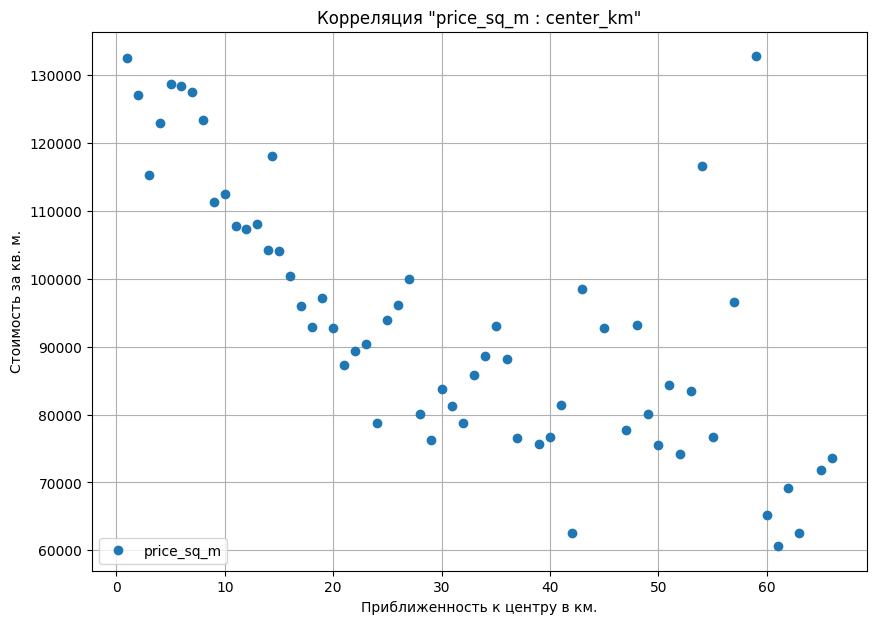

Коэффициент корреляции Пирсона между приближенностью к центру и ценой за кв. м.: -0.39


In [103]:
# приближенность к центру и цена
good_data.pivot_table(
    index='center_km', 
    values='price_sq_m', 
).plot(
    grid=True, 
    style='o', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость за кв. м.')
plt.xlabel('Приближенность к центру в км.')
plt.title('Корреляция "price_sq_m : center_km"')
plt.show()
print('Коэффициент корреляции Пирсона между приближенностью к центру и ценой за кв. м.:',
      good_data['center_km'].corr(good_data['price_sq_m']).round(2))

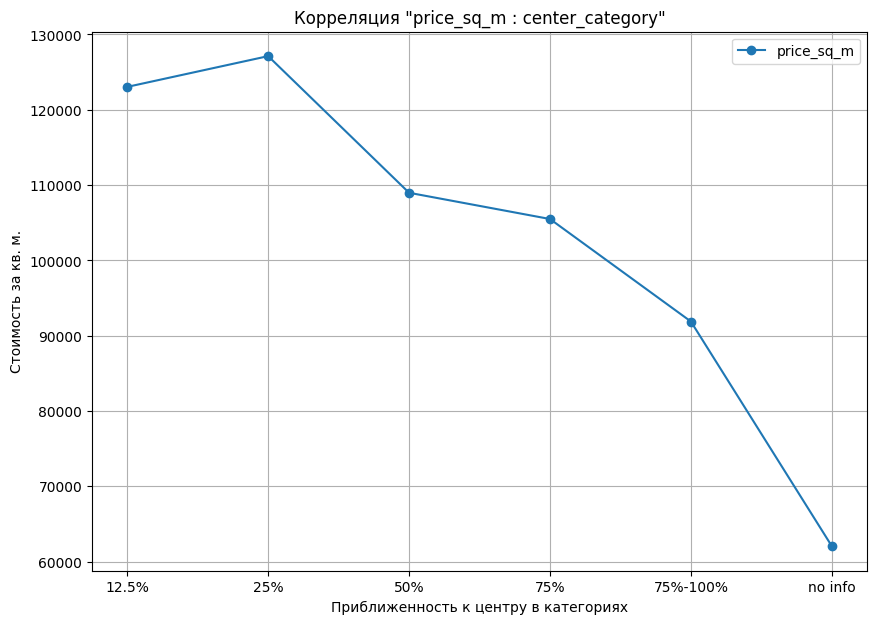

,mean,count,ratio
center_category,,,
12.5%,123022.99,1440,6.20
25%,127104.88,2298,9.89
50%,108963.84,4083,17.57
75%,105480.84,4293,18.48
75%-100%,91874.87,5614,24.16
no info,62054.42,5507,23.70


In [104]:
# приближенность к центру в категориях и цена
sq_m_center_categ = good_data.pivot_table(
    index='center_category', 
    values='price_sq_m', 
    aggfunc=['mean', 'count']
)
sq_m_center_categ.plot(
    grid=True, 
    y = 'mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость за кв. м.')
plt.xlabel('Приближенность к центру в категориях')
plt.title('Корреляция "price_sq_m : center_category"')
plt.show()

sq_m_center_categ['ratio'] = (sq_m_center_categ['count'] / sq_m_center_categ['count'].sum() * 100).round(2)
sq_m_center_categ.columns = ['mean', 'count', 'ratio']
sq_m_center_categ['mean'] = sq_m_center_categ['mean'].round(2)
sq_m_center_categ


**Вывод**: 

Корреляция между расстоянием до центра и ценой за квадратный метр объекта составляет -0.39, что указывает на умеренную обратную связь. Это значит, что чем ближе объект к центру, тем выше стоимость квадратного метра. Это связано с тем, что в центральных районах обычно строятся более элитные жилищные комплексы, и такие дома считаются более престижными и удобными для жизни.

Также хочется отметить сводную таблицу, показывающую, что если категоризировать приближенность к центру на перцентили, то самая высокая средняя стоимость за квадратный метр выходит в промежутке между половиной первого перцентиля и первым перцентилем - 127,104 руб. за квадратный метр. Таких объявлений всего 10%. Тогда как в отдаленных местах от центра средняя стоимость варьируется от 91,874 руб. до 62,054 руб., и таких объявлений около 48%.

#### last_price_mil : parks_around3000

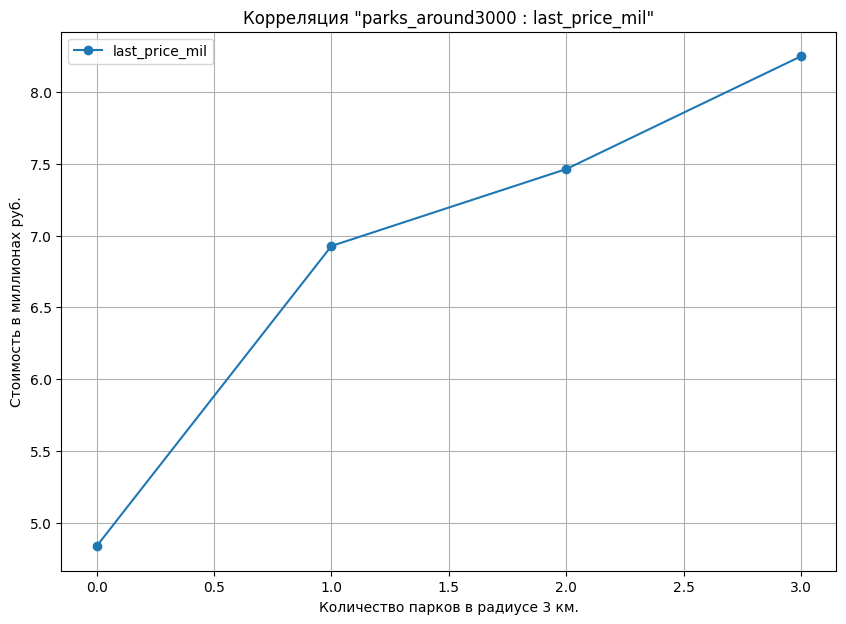

Коэффициент корреляции Пирсона между количеством парков в радиусе 3 км. и стоимостью объекта: 0.29


,mean,count,ratio
parks_around3000,,,
0,4.837801,15489,66.662
1,6.927115,5542,23.852
2,7.462562,1640,7.058
3,8.247827,564,2.427


In [105]:
# парки в радиусе 3 км. и цена
last_parks = good_data.pivot_table(
    index='parks_around3000', 
    values='last_price_mil', 
    aggfunc=['mean', 'count']
)
last_parks.plot(
    grid=True, 
    y='mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Количество парков в радиусе 3 км.')
plt.title('Корреляция "parks_around3000 : last_price_mil"')
plt.show()
print('Коэффициент корреляции Пирсона между количеством парков в радиусе 3 км. и стоимостью объекта:',
      good_data['parks_around3000'].corr(good_data['last_price_mil']).round(2))

last_parks['ratio'] = (last_parks['count'] / last_parks['count'].sum() * 100).round(3)
last_parks.columns = ['mean', 'count', 'ratio']
last_parks

**Вывод**: 

Корреляция между количеством парков в радиусе 3 километров и ценой за объект составляет 0.29, что указывает на слабую прямую связь. Это может говорить о том, что наличие парков поблизости увеличивает стоимость объекта, но не намного. Парки могут улучшать качество жизни в районе, делая его более привлекательным для покупателей. Наличие нескольких парков вокруг объекта может быть огромным плюсом для любителей прогулок по вечерам, так как они точно не заскучают и будут иметь возможность выбирать куда пойти в тот или иной день!

Также хочется заметить, что в 66.7% случаях вокруг объекта нет ни одного парка. Лишь в 2.4% случаев вокруг объекта есть аж целых 3 парка!

#### last_price_mil : ponds_around3000

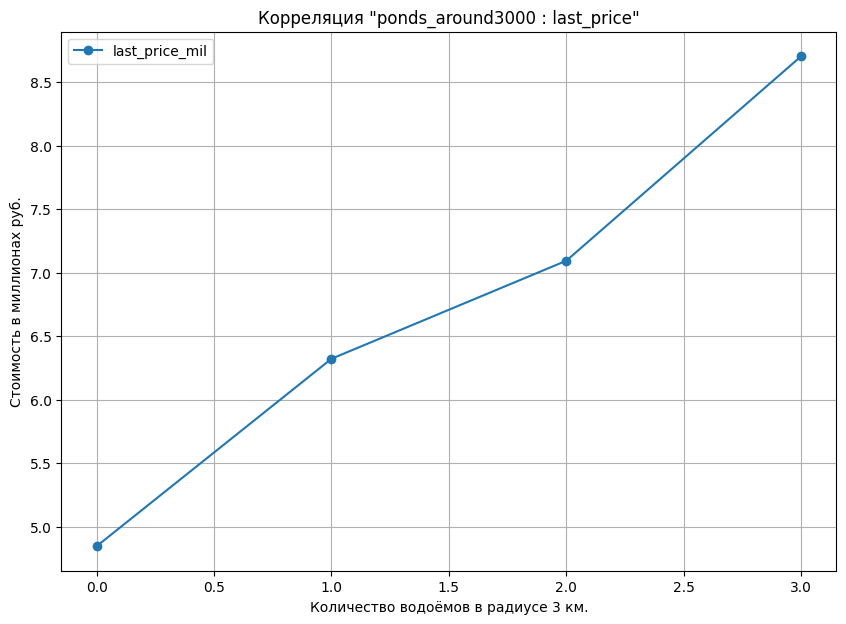

Коэффициент корреляции Пирсона между количеством водоёмов в радиусе 3 км. и стоимостью объекта: 0.3


,mean,count,ratio
ponds_around3000,,,
0,4.848097,14469,62.272
1,6.323123,5598,24.093
2,7.094522,1805,7.768
3,8.704013,1363,5.866


In [106]:
# водоёмы в радиусе 3 км. и цена
last_ponds = good_data.pivot_table(
    index='ponds_around3000', 
    values='last_price_mil', 
    aggfunc=['mean', 'count']
)
last_ponds.plot(
    grid=True, 
    y='mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Количество водоёмов в радиусе 3 км.')
plt.title('Корреляция "ponds_around3000 : last_price"')
plt.show()
print('Коэффициент корреляции Пирсона между количеством водоёмов в радиусе 3 км. и стоимостью объекта:',
      good_data['ponds_around3000'].corr(good_data['last_price_mil']).round(2))

last_ponds['ratio'] = (last_ponds['count'] / last_ponds['count'].sum() * 100).round(3)
last_ponds.columns = ['mean', 'count', 'ratio']
last_ponds

**Вывод**: 

Корреляция между количеством прудов в радиусе 3 километров и ценой за объект составляет 0.3, что указывает на слабую прямую связь. Это может говорить о том, что наличие прудов поблизости может немного увеличивать стоимость объекта. Пруды могут делать район более живописным и привлекательным для покупателей. Логика такая же, как и с парками.

Также отмечу, что в 62.3% случаях вокруг объекта нет ни одного водоема. Лишь в 5.9% случаев вокруг объекта есть аж целых 3 водоёма!

#### last_price_mil : price_sq_m

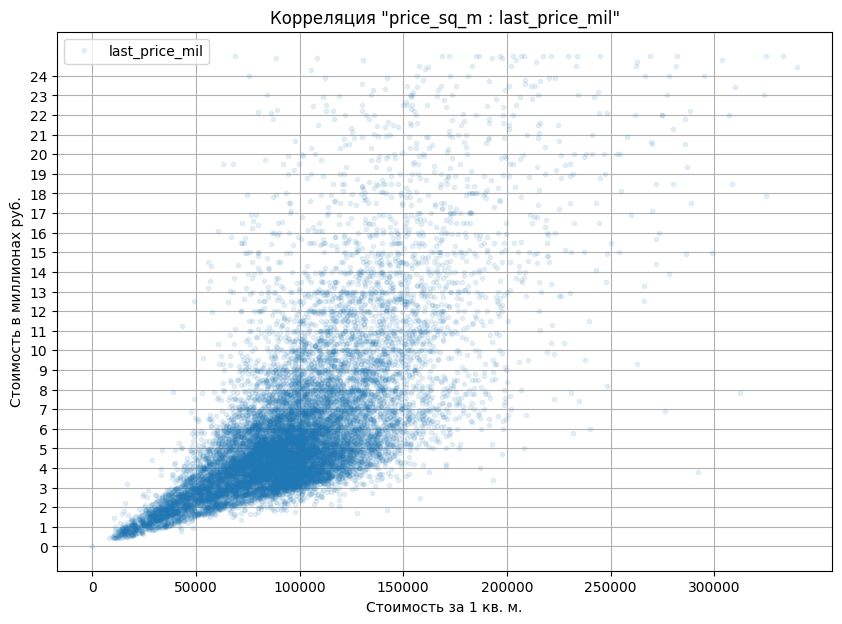

Коэффициент корреляции Пирсона между ценой за кв. м. и стоимостью объекта: 0.64


In [107]:
# стоимость за кв. м. и цена
good_data.query('price_sq_m <= 350000'
).pivot_table(
    index='price_sq_m', 
    values='last_price_mil', 
).plot(
    grid=True, 
    style='.', 
    figsize=(10, 7),
    alpha=0.1,
)
plt.yticks(range(0, 25, 1))
plt.xticks(range(0, 350000, 50000))
plt.ylabel('Стоимость в миллионах руб.')
plt.xlabel('Стоимость за 1 кв. м.')
plt.title('Корреляция "price_sq_m : last_price_mil"')
plt.show()

print('Коэффициент корреляции Пирсона между ценой за кв. м. и стоимостью объекта:',
      good_data['price_sq_m'].corr(good_data['last_price_mil']).round(2))

**Вывод**: 

Корреляция между ценой за квадратный метр и ценой на объект составляет 0.64, что указывает на сильную прямую связь. Это означает, что чем выше цена за квадратный метр, тем выше общая стоимость объекта. И правда, ведь общая стоимость объекта является произведением цены за квадратный метр на общую площадь объекта.

#### last_price_mil : floor_type

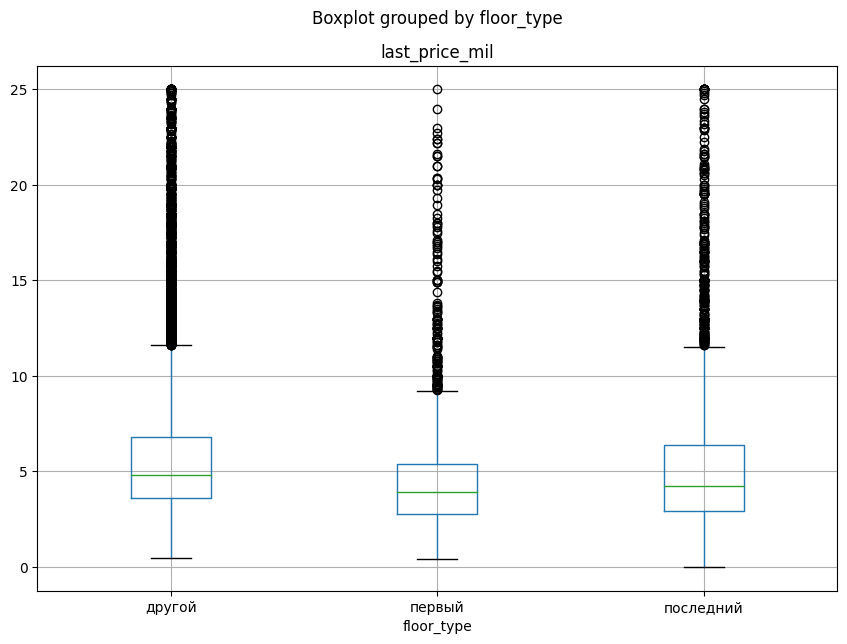

,count,mean,ratio
floor_type,,,
другой,17104,99832.89,73.61
первый,2894,80652.03,12.46
последний,3237,87593.20,13.93


In [108]:
good_data.boxplot(column='last_price_mil', by='floor_type', figsize=(10, 7))
plt.show()

price_floor = good_data.pivot_table(
    index='floor_type', 
    values='price_sq_m',
    aggfunc=['count', 'mean']
)

price_floor['ratio'] = (price_floor['count'] / price_floor['count'].sum() * 100).round(2)
price_floor.columns = ['count', 'mean', 'ratio']
price_floor['mean'] = price_floor['mean'].round(2)
price_floor

**Вывод**: 

В 73.6% случаев объекты находятся ни на первом, ни на последнем этаже. Стоимость за кв. м. таких объектов в среднем достигает 99,832 руб. 

Объекты на первых и последних этажах встречаются реже - 12.5% и 13.9% соответственно. Стоимость за кв. м. таких объектов значительно ниже - 80,652 руб. и 87,593 руб. за квадратный метр соответственно.

#### last_price_mil : weekday / month / year

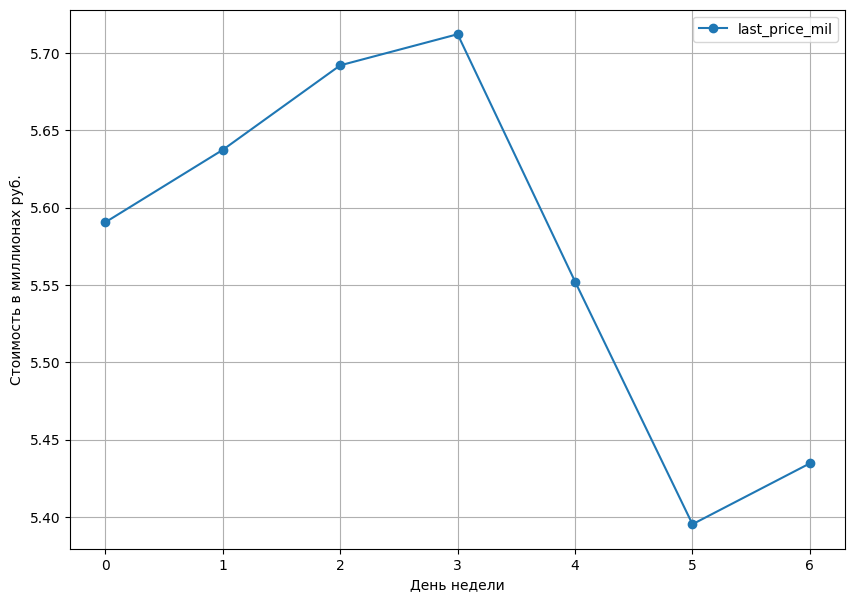

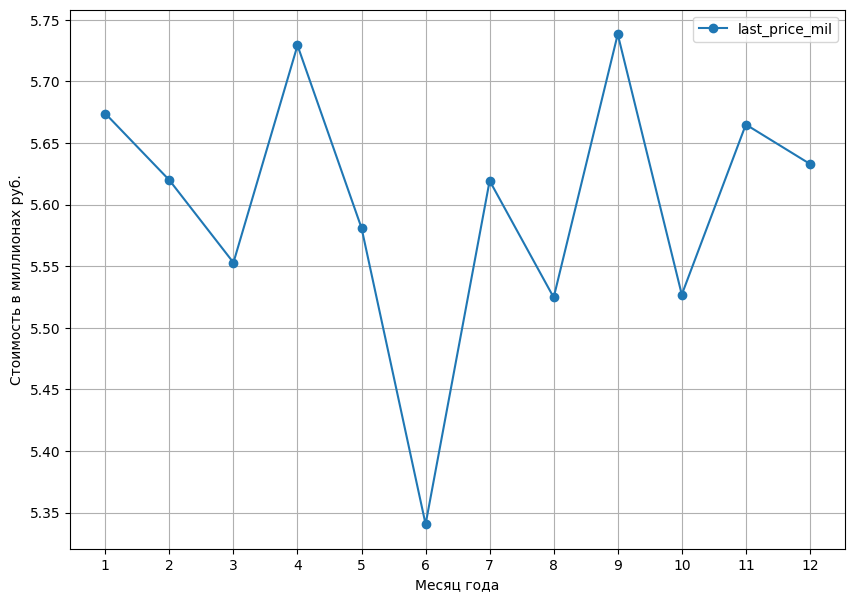

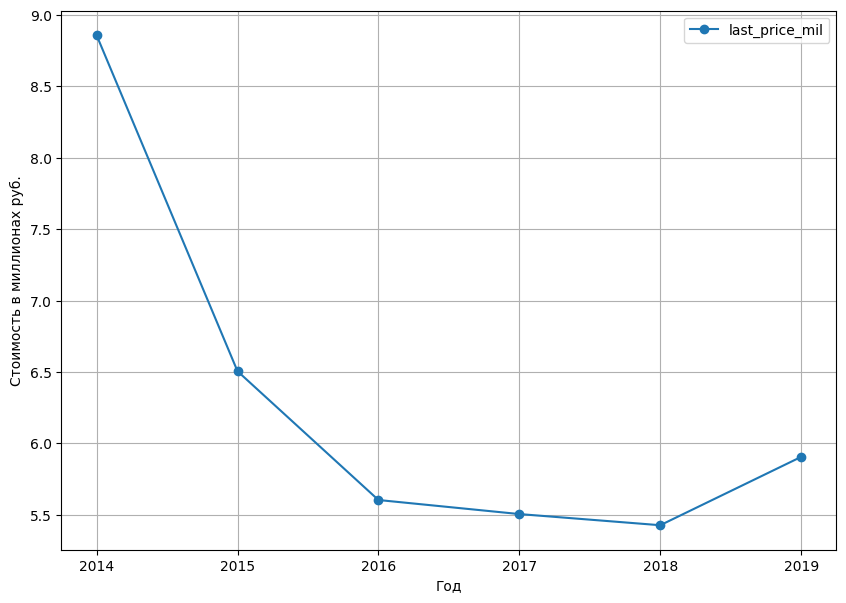

In [109]:
# день размещения к цене
day_price = good_data.pivot_table(
    index='weekday', 
    values='last_price_mil',
    aggfunc=['mean', 'count']
)
day_price.plot(
    grid=True,
    y='mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.xlabel('День недели')
plt.ylabel('Стоимость в миллионах руб.')
plt.show()

# месяц размещения к цене
month_price = good_data.pivot_table(
    index='month', 
    values='last_price_mil',
    aggfunc=['mean', 'count']
)
month_price.plot(
    grid=True, 
    y='mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.xticks(range(1, 13, 1))
plt.xlabel('Месяц года')
plt.ylabel('Стоимость в миллионах руб.')
plt.show()


# год размещения к цене
year_price = good_data.pivot_table(
    index='year', 
    values='last_price_mil',
    aggfunc=['mean', 'count']
)
year_price.plot(
    grid=True, 
    y='mean',
    style='o-', 
    figsize=(10, 7),
    alpha=1,
)
plt.xlabel('Год')
plt.ylabel('Стоимость в миллионах руб.')
plt.show()

In [110]:
day_price['ratio'] = (day_price['count'] / day_price['count'].sum() * 100).round(3)
day_price.columns = ['mean', 'count', 'ratio']
day_price.sort_values(by='ratio')

,mean,count,ratio
weekday,,,
6,5.434696,1668,7.179
5,5.395354,1896,8.160
0,5.590542,3535,15.214
2,5.691989,3898,16.776
4,5.552240,3933,16.927
1,5.637354,4113,17.702
3,5.712106,4192,18.042


In [111]:
month_price['ratio'] = (month_price['count'] / month_price['count'].sum() * 100).round(3)
month_price.columns = ['mean', 'count', 'ratio']
month_price.sort_values(by='mean')

,mean,count,ratio
month,,,
6,5.340484,1719,7.398
8,5.524630,1707,7.347
10,5.526910,2092,9.004
3,5.552915,2543,10.945
5,5.580982,1248,5.371
7,5.619385,1658,7.136
2,5.619846,2591,11.151
12,5.633074,1601,6.890
11,5.665053,2319,9.981


In [112]:
year_price['ratio'] = (year_price['count'] / year_price['count'].sum() * 100).round(3)
year_price.columns = ['mean', 'count', 'ratio']
year_price.sort_values(by='mean')

,mean,count,ratio
year,,,
2018,5.427057,8409,36.191
2017,5.505181,8019,34.513
2016,5.603660,2717,11.694
2019,5.905592,2823,12.150
2015,6.505592,1143,4.919
2014,8.858494,124,0.534


**Вывод**: 

  1. **Стоимость объекта в зависимости от дня недели** - Взглянем на график и на сводную таблицу - под конец недели стоимость, за которую выставляется объект, заметно падает. Вероятно, это связано с тем, что желание продать объект в будние дни возрастает, также как возрастают амбиции и желание продать подороже. С наступлением выходных продавцы могут потратить больше времени на исследование рынка и заметить, что стоимость их жилья немного ниже ожидаемой. Таким образом можно сделать вывод - в будние дни желаемая стоимость объекта будет выше, чем стоимость которая будет указана в выходные.
  2. **Стоимость объекта в зависимости от месяца года** - Взглянем на график и на сводную таблицу - к началу лета стоимость на жилье заметно падает, по сравнению с другими месяцами. Осмелюсь предположить, что логика может работать как с зимней одеждой - зимой стоимость на зимнюю одежду выше, чем летом, потому что в это время увеличивается в ней нужда. Соответственно мое предположение заключается в том, что по мере наступления зимы желание переехать в свой собственный уголок возрастает, тем самым увеличивая спрос, тем самым увеличивая цены. А противоположностью зимы как раз является лето, когда люди тратят деньги на отпуска, на отмечание праздников, выпускных и прочего прочего. Как раз к лету желание тратить финансы на покупку объектов падают, тем самым возможно занижают цены на рынке.
  3. **Стоимость объекта в зависимости от года** -  Как видно на графике и на сводной таблице, средняя стоимость за объект в 2014 году достигала невероятных 8.8 миллионов руб. С каждым годом после этого стоимость падала до 2018 года и средней стоимостью 5.4 миллиона руб., начиная с которого стоимость понемногу начала повышаться. Вероятно это как-то связано с валютным кризисом в России (2014 по 2016 год), когда произошло "резкое ослабление российского рубля по отношению к иностранным валютам". Дальнейшее падение стоимости, вероятно, являлось следствием кризиса. 

### Задача на подсчет средней цены за кв. м. в 10 населённых пунктах

Для начала определим, какие населённые пункты являются самыми большими по численности населения.

In [113]:
highest_locality = good_data.groupby('locality_name')['last_price'].count().sort_values(ascending=False).head(10)

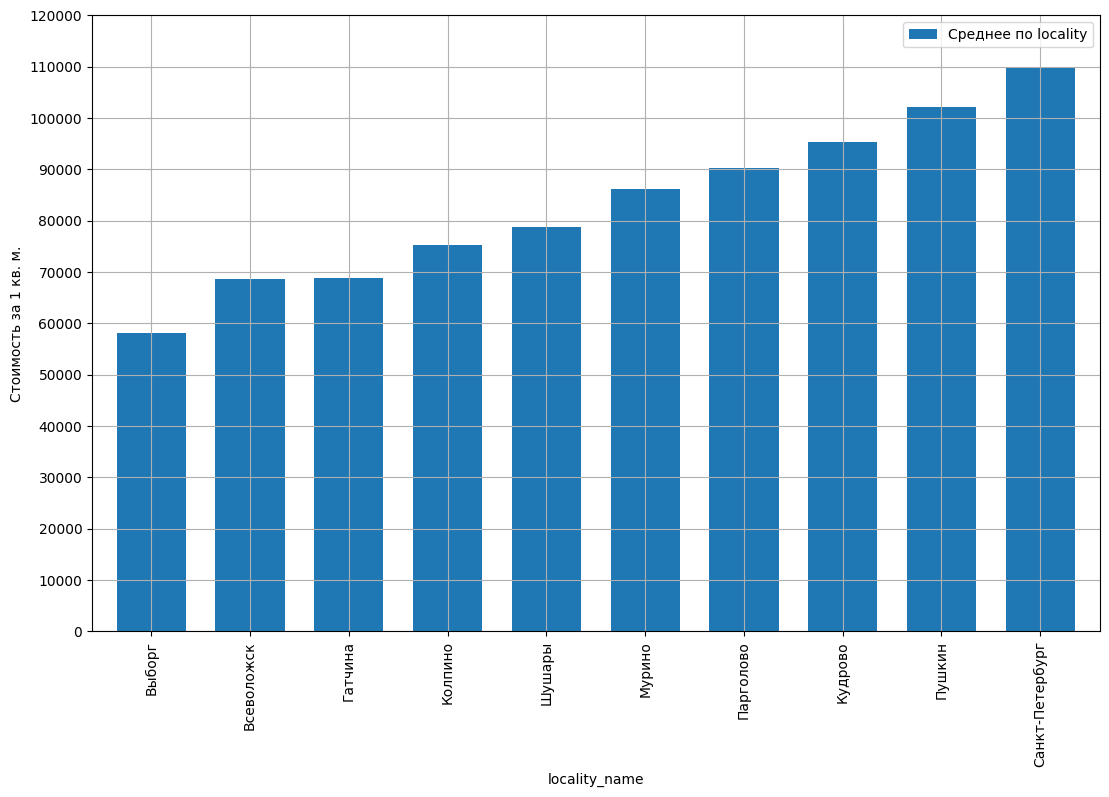

,Количество,Среднее по locality,Отношение к среднему общему
locality_name,,,
Санкт-Петербург,15266,109733.46,114.62
Мурино,590,86087.51,89.92
Кудрово,472,95324.93,99.57
Шушары,440,78677.36,82.18
Всеволожск,398,68654.47,71.71
Пушкин,362,102151.56,106.70
Колпино,337,75333.30,78.69
Парголово,327,90175.91,94.19
Гатчина,307,68746.15,71.81


In [114]:
highest_locality = good_data.pivot_table(index='locality_name', values='price_sq_m', aggfunc=['count', 'mean'])
highest_locality.columns = ['Количество', 'Среднее по locality']
highest_locality['Среднее по locality'] = highest_locality['Среднее по locality'].round(2)
highest_locality['Отношение к среднему общему'] = ((highest_locality['Среднее по locality'] / good_data['price_sq_m'].mean()) * 100).round(2)


highest_locality.sort_values(by='Количество', ascending=False).head(10).sort_values(by='Среднее по locality').plot(    
    y='Среднее по locality',
    kind='bar',
    figsize=(13,8),
    width=0.7,
    grid=True,
)
plt.yticks(range(0, 130000, 10000))
plt.ylabel('Стоимость за 1 кв. м.')
plt.show()

highest_locality.sort_values(by='Количество', ascending=False).head(10)

**Вывод**:

1. Из имеющейся выборки **10 самых населенных из пунктов** являются (*в порядке убывания*): Санкт-Петербург с огромным показателем в  15315 объявлений, Мурино, Кудрово, Шушары, Всеволожск, Пушкин, Колпино, Парголово, Гатчина, Выборг.
2. **Самыми дорогими** являются:
 - Санкт-Петербург - 109,864 руб. за кв. м., а также 114.57% от средней цены за кв. м. по датафрейму
 - Пушкин - 102,151 руб. за кв. м., и 106.7% от средней цены за кв. м. по датафрейму
3. **Самыми дешевыми** являются:
 - Выборг - 58,141 руб. за кв. м. и невероятно низкие 60.73% от средней цены за кв. м. по датафрейму
 - Всеволожск и Гатчина находятся на одном уровне - 68,654 руб. и 68,746 руб. кв. м.. Также они имеют низкую стоимость относительно средней цены за кв. м. - 71.71% и 71.81% соответственно.

### Задача на подсчет средней цены каждого километра Санкт-Петербурга

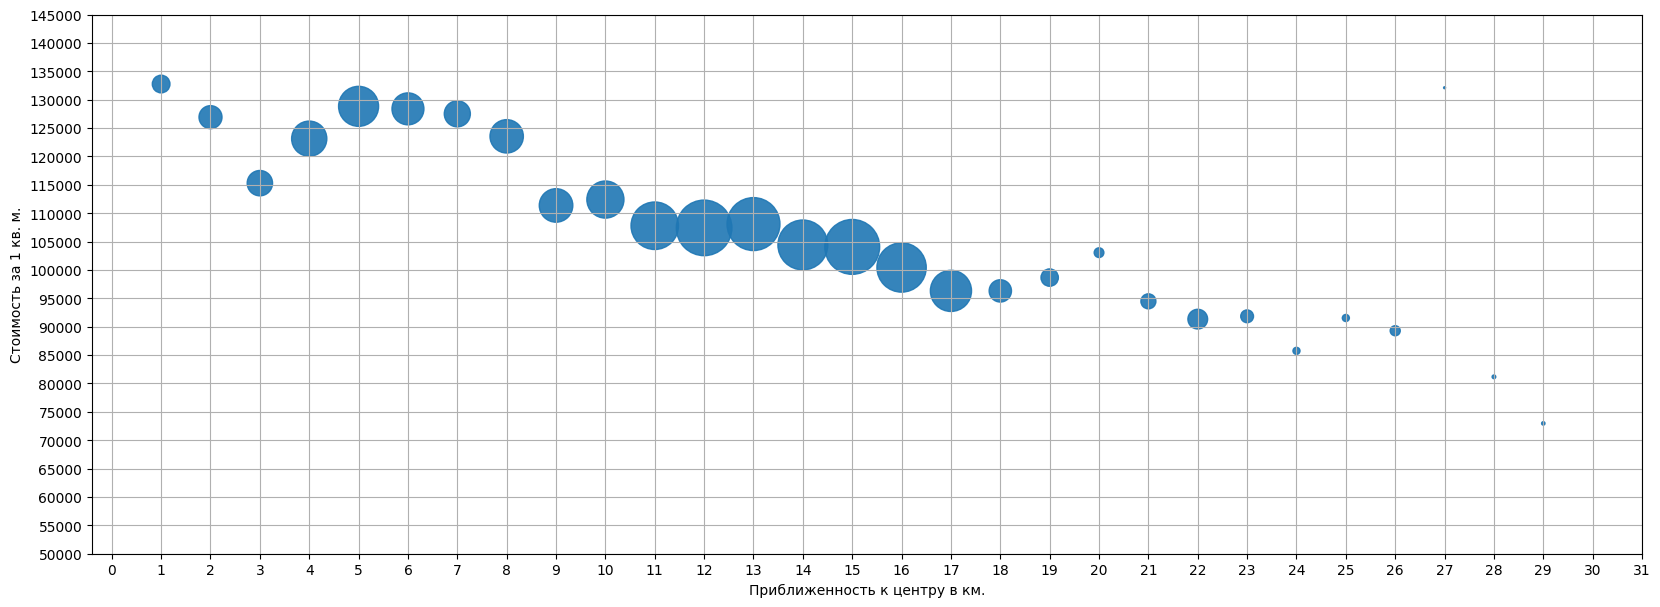

In [115]:
# создадим датафрейм, который будет содержать лишь данные по Санкт-Петербургу
spb_data = good_data.query('locality_name == "Санкт-Петербург"').copy()

# избавимся от пропущенных значений в столбце "center_km"
spb_data.dropna(subset=['center_km'], inplace=True)

# приведем столбец center_km в целочисленный тип
spb_data.loc[:, 'center_km'] = spb_data['center_km'].astype('int')

# проверяем полученные значения
spb_data.groupby('center_km')['last_price'].count()


# создадим сводную таблицу, в которой будет два столбца - среднее значение и количество таких значений
spb_data_pivot = spb_data.pivot_table(
    index='center_km',
    values='price_sq_m',
    aggfunc=['mean', 'count'],
    
).reset_index()

# назовем колонки своими именами
spb_data_pivot.columns = ['center_km','mean price_sq_m', 'count']

# отсортируем по индексу
spb_data_pivot = spb_data_pivot.sort_index()

spb_data_pivot['ratio to mean SPB'] = (spb_data_pivot['mean price_sq_m'] / spb_data['price_sq_m'].mean() * 100).round(2)
spb_data_pivot['mean price_sq_m'] = spb_data_pivot['mean price_sq_m'].round(2)
# построим гистограмму по полученной сводной таблице
spb_data_pivot.plot(
    y='mean price_sq_m',
    x='center_km',
    kind='scatter',
    grid=True,
    figsize=(20,7),
    alpha=0.9,
    s=spb_data_pivot['count']
)
plt.yticks(range(50000, 150000, 5000))
plt.xticks(range(0, 32, 1))
plt.ylabel('Стоимость за 1 кв. м.')
plt.xlabel('Приближенность к центру в км.')

plt.show()

In [116]:
# посмотрим на самые "дорогие" данные
spb_data_pivot.head(10)

,center_km,mean price_sq_m,count,ratio to mean SPB
0,1,132766.98,162,121.06
1,2,126928.87,275,115.74
2,3,115296.02,334,105.13
3,4,123135.44,643,112.28
4,5,128835.78,831,117.48
5,6,128391.91,530,117.07
6,7,127516.91,353,116.27
7,8,123550.46,578,112.66
8,9,111369.07,584,101.55
9,10,112406.08,715,102.50


In [117]:
# посмотрим на хвост таблицы
spb_data_pivot.query('count > 4').tail(10)

,center_km,mean price_sq_m,count,ratio to mean SPB
18,19,98652.74,157,89.95
19,20,103045.18,49,93.96
20,21,94469.58,117,86.14
21,22,91330.43,202,83.28
22,23,91828.52,85,83.73
23,24,85736.90,26,78.18
24,25,91531.37,26,83.46
25,26,89285.88,53,81.41
27,28,81161.91,7,74.01
28,29,72953.36,6,66.52


In [118]:
# посмотрим на самые дешевые объекты
spb_data_pivot.query('count > 4').sort_values(by='mean price_sq_m', ascending=True).head(10)

,center_km,mean price_sq_m,count,ratio to mean SPB
28,29,72953.36,6,66.52
27,28,81161.91,7,74.01
23,24,85736.90,26,78.18
25,26,89285.88,53,81.41
21,22,91330.43,202,83.28
24,25,91531.37,26,83.46
22,23,91828.52,85,83.73
20,21,94469.58,117,86.14
17,18,96308.94,259,87.82
16,17,96309.49,879,87.82


Моя подруга из Санкт-Петербурга поведала мне, что является центром города. Условно центром можно назвать окружность начинающуюся от станции метро "Чкаловская" и заканчивающуюся на станции метро "Обводный канал". Сообразив линейкой на Яндекс.Картах находим диаметр такой окружности - 7 км. Радиусом же такой окружности будет 3.5 км., но, пожалуй, можно округлить в большую сторону. Таким образом посчитаем отдельно, сколько же в среднем стоит квадратный метр в центральной части Санкт-Петербурга:

In [119]:
print('Средняя стоимость за квадратный метр в самом центре равна:',spb_data_pivot.query('center_km <=4')['mean price_sq_m'].mean().round(), 'руб.')
print('Средняя стоимость за квадратный метр в радиусе с 9 км. до 17 км. равна:',spb_data_pivot.query('center_km >=9 & center_km <=17')['mean price_sq_m'].mean().round(), 'руб.')
print('Средняя стоимость за квадратный метр в пределах 8 км равна:',spb_data_pivot.query('center_km <=8')['mean price_sq_m'].mean().round(), 'руб.')
print('Средняя стоимость от посчитанных средних цен на квадратный метр равна:', spb_data_pivot['mean price_sq_m'].mean().round())

Средняя стоимость за квадратный метр в самом центре равна: 124532.0 руб.
Средняя стоимость за квадратный метр в радиусе с 9 км. до 17 км. равна: 105808.0 руб.
Средняя стоимость за квадратный метр в пределах 8 км равна: 125803.0 руб.
Средняя стоимость от посчитанных средних цен на квадратный метр равна: 106452.0


**Вывод**:

1. Из имеющихся данных заметно, что **бОльшая часть объявлений** располагается в пределах **17 км.** от центра города.
2. Стоимость за единицу кв. м. в такой средней отдаленности (а это **с 9 по 17 км.**) **от 95 до 110 тыс. руб.**, а точнее среднее **105,808** руб.
3. В районах, располагающихся **ближе всего к центру** (а это как мы выяснили **в пределах 4 км**) средняя стоимость за кв. м. равняется **124,532 руб.**
4. Средняя цена от средних цен на кв. м. равна **106,452 руб.**
5. Все помещения, располагающиеся в пределах **10 км.** к центру дороже средней стоимости за 1 кв.м. по городу Санкт-Петербург
6. Самые дешевые объявления располагаются в радиусе **29 км.** от центра и имеют стоимость за 1 кв. м. в **72953 руб.**. В таком радиусе стоимость в **66.52%** от средней цены по городу.
7. Следом за ними идут объявления в **28 и 24 км.** и имеют стоимость за 1 кв. м. в **81,161 руб. и 85,736 руб.**, что является **74.10% и 78.18%** соответственно от средней стоимости по городу
8. Отдельно хочу отметить самый дорогой радиус объявлений в **1 км.** - **132,766.98 руб.** за кв. м., а также значение в **121.06%** от средней стоимости за 1 кв. м. по городу !

## Общий вывод

 1. Предварительно **изучив общую информацию** на **первой стадии** работы с датафреймом мы и представить не могли, какой объем работы может потребоваться. Изначально было понятно, что есть огромное количество неточностей, пропусков, маленьких и серьезных проблем с данными, но последовательный разбор по всему датафрейму привел нас к итоговому результату "*не так страшен чёрт, как его малюют*".
 2. На **второй стадии** работы, в **предобработке данных**, мы провели кропотливую работу по разбору каждого из столбцов, удалили дубликаты, заполнили где можно пропуски, где нельзя - оставили, а где-то придумали целую систему по заполнению данных. Не забыли и поменять типы данных на более корректные там, где это возможно.Несомненно, все эти усилия сказались на эффективности анализа и корректности данных. 
 3. **Третья стадия** работы заключалась в **добавлении новых столбцов**. Для большего удобства работы с данными были добавлены разные столбцы - начиная от стоимости объекта в миллионах рублей, заканчивая приближенностью к центру в километрах. Чем больше вариации данных тем больше возможностей обработать и найти какие-то интересные вывод!
 4. **Самые интересные выводы** были подведены в **четвертой стадии** работы с датафреймом. 
  1. *Аномалии*:
  - Была найдена аномалия в виде снижения количества объявлений с жилыми площадями в категории **20-25 кв. м.** ( в сравнении с другими популярными категориями), но найти точную связь такой аномалии, к сожалению, не удалось.
  - Была найдена аномалия в виде увеличения количества объявлений снятых с сервиса в **45, 60 и 90 дней**. Действительно, причины снятия объявлений в эти дни связана с условиями работы сервиса.
  2. *Связи стоимости объекта с различными параметрами*:
   - *Общая площадь* - чем больше выставляемый на продажу объект, тем выше его стоимость. Коэф. корреляции **0.78**
   - *Жилая площадь / площадь кухни* - чем больше жилая площадь объекта и площадь кухни, тем выше его стоимость. Коэф. корреляции **0.65, 0.62** соответственно.
   - *Количество комнат* - чем больше комнат в объекте - тем выше его стоимость. Коэф. корреляции **0.52**
   - *Высота потолка* - объекты с более высокими потолками зачастую стоят дороже. Коэф. корреляции **0.46**. *Интересный факт - чем ближе объект к центру города, тем больше вероятность, что в таком объекте потолки будут выше.*
   - *Количество парков и водоёмов в радиусе 3 км.* - наличие парков и водоёмов в близи объекта увеличивает его стоимость, но не намного. Коэф. корреляции **0.29**
   - *Стоимость за кв. м.* - чем выше цена за квадратный метр, тем выше общая стоимость объекта. Коэф. корреляции **0.64**
   - *Тип этажности* - объекты на первых и последних этажах встречаются редко - **12.5%** и **13.9%** соответственно. В среднем, стоимость за кв. м. таких объектов - **80,652 руб.** и **87,593 руб.** соответственно. На других же этажах стоимость за кв. м. - **99,832 руб.**
   - *Дата выставления объявления* - день недели, месяц, год - в объявлениях выставленных в конце недели зачастую стоимость ниже, чем в другие дни выставления. Объекты с самыми низкими ценами чаще всего выставляются в июне, тогда как самые дорогие с наступлением зимы. С **2014 по 2018** год было **сильное падение цен** на различные объекты в связи с **валютным кризисом в России**. К **2019** же году стоимость начала понемногу **повышаться**.
  3. *Значения средних цен в различных условиях*:
   - **Санкт-Петербург** - в среднем **109,864 руб.** за кв. м., а также **114.57%** от средней цены за кв. м. по датафрейму
   - **Выборг** - в среднем **58,141 руб.** за кв. м. и невероятно низкие **60.73%** от средней цены за кв. м. по датафрейму
   - В районах, располагающихся ближе всего к **центру Санкт-Петербурга**, средняя стоимость за кв. м. составляет **124,532 руб.**
   - С отдалением от центра города стоимость на жилье заметно снижается.
 